<a href="https://colab.research.google.com/github/Marrmotta/dissertation/blob/main/Experiment_1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1A Notebook

## Notebook Purpose & Flow

1. **Setup:** Installs necessary libraries and authenticates with Google Sheets.
2. **Data Import & Preprocessing:** Loads the raw data from the “Experiment 1A Coded” sheet, cleans demographics, and creates a long-format dataset with key variables.
3. **Descriptive Statistics & Exploratory Checks:** Summarizes demographics, social media usage, and calculates descriptive stats for correct/misinformed responses.
4. **Mixed Effects Models & ANCOVA:** Fits logistic regressions (mixed effects), ANCOVAs on proportion data, includes robust-regression variants.
5. **Effect Size & Plotting:** Calculates Hedge’s g, generates visualizations (bar plots) for main effects and interactions.
6. **Optional Analyses:** Bootstrapping, robust mixed-effects, etc.
7. **Appendix/Readme:** Final notes and references, plus the readme; saved out separately in github.

**Key Variables**  
- `Correct_Binary`: 1 = Correct, 0 = Otherwise  
- `Misinformed_Binary`: 1 = Misinformed, 0 = Otherwise  
- `Familiarity`: High Familiarity vs. Low Familiarity items  
- `Fact_Framing`: Accurate, Neutral, or Misleading  
- `Presentation`: Scrolling vs. Page-based  

This notebook forms the backbone of **Experiment 1A** analyses, aligning with the final write-up sections.


## Data Import and Preprocessing

In this section, we:
1. Load raw data from 'Experiment 1A Coded' in Google Sheets.
2. Clean demographics (e.g., standardize gender labels).
3. Convert relevant columns (_coded) to integers for analysis.
4. Summarize key demographic variables and social media usage.

In [1]:
# Install necessary libraries
!pip install gspread google-auth google-auth-oauthlib google-auth-httplib2

# Import libraries
import gspread
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc

# Upload credentials file
from google.colab import files
uploaded = files.upload()  # Select gc 'credentials.json'

Saving credentials.json to credentials.json


In [2]:
# Check the uploaded file name
credentials_filename = list(uploaded.keys())[0]

# Define the scopes
SCOPE = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]

# Load credentials
creds = Credentials.from_service_account_file(credentials_filename, scopes=SCOPE)

# Authorize and create the client
gc = gspread.authorize(creds)

In [22]:
# Create helper functions
# Define the function to calculate Hedge's g
def hedges_g(mean1, mean2, sd1, sd2, n1, n2):
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    g = (mean1 - mean2) / pooled_sd
    correction_factor = 1 - (3 / (4 * (n1 + n2) - 9))
    hedges_g_value = g * correction_factor
    return hedges_g_value

# Define the function to categorize responses
def categorize_response(response):
    if response == -99:
        return 'Blank'
    elif response == 0:
        return 'Wrong'
    elif response == 1:
        return 'Correct'
    elif response == 2:
        return 'Misinformed'
    else:
        return None

# Function to process participant data, breaking out High Familiarity and Low Familiarity responses
def process_participant_data(participant_row, counterbalance_df, gk_items):
    """
    Process participant data to calculate counts for different response categories,
    including breakdowns by fact framing and familiarity.

    Args:
        participant_row (Series): A row of participant data.
        counterbalance_df (DataFrame): Counterbalancing guide for items.
        gk_items (list): List of general knowledge item numbers.

    Returns:
        dict: Counts of responses across categories, fact framing, and familiarity levels.
    """
    # Initialize result dictionary
    result = {
        'Total Blank': 0, 'Total Wrong': 0, 'Total Correct': 0, 'Total Misinformed': 0,
        'Accurate Blank': 0, 'Accurate Wrong': 0, 'Accurate Correct': 0, 'Accurate Misinformed': 0,
        'Neutral Blank': 0, 'Neutral Wrong': 0, 'Neutral Correct': 0, 'Neutral Misinformed': 0,
        'Misleading Blank': 0, 'Misleading Wrong': 0, 'Misleading Correct': 0, 'Misleading Misinformed': 0,
        'High Familiarity Blank': 0, 'High Familiarity Wrong': 0, 'High Familiarity Correct': 0, 'High Familiarity Misinformed': 0,
        'Low Familiarity Blank': 0, 'Low Familiarity Wrong': 0, 'Low Familiarity Correct': 0, 'Low Familiarity Misinformed': 0
    }

    # Iterate through each general knowledge item
    for gk_num in gk_items:
        row = counterbalance_df[counterbalance_df['GK'] == gk_num].iloc[0]
        familiarity = row['Familiarity']  # 0 = High Familiarity, 1 = Low Familiarity
        experiment = 'E1'
        version = participant_row['Version']
        version_map = {'A': 'A', 'B': 'B', 'C': 'C'}
        frame_col = f'{experiment}{version_map[version]}'  # Column to identify fact framing
        frame = row[frame_col]  # Fact framing code (1 = Accurate, 2 = Neutral, 3 = Misleading)
        response_col = f'GK{gk_num}_coded'
        response = participant_row[response_col]

        # Categorize response
        category = categorize_response(response)
        if category is None:
            continue  # Skip if response is invalid

        # Increment total category counts
        result[f'Total {category}'] += 1

        # Increment counts by fact framing
        frame_type = 'Accurate' if frame == 1 else 'Neutral' if frame == 2 else 'Misleading'
        result[f'{frame_type} {category}'] += 1

        # Increment counts by familiarity
        familiarity_label = 'High Familiarity' if familiarity == 0 else 'Low Familiarity'
        result[f'{familiarity_label} {category}'] += 1

    return result

# Create a function to get the fact framing based on the version and item
# def get_fact_framing(version, item):
#     version_column = f'E1{version}'
#     item_index = counterbalance_data['GK'].index(int(item.split('_')[0][2:]))
#     framing_code = counterbalance_data[version_column][item_index]
#     return 'Accurate' if framing_code == 1 else ('Neutral' if framing_code == 2 else 'Misleading')

def get_fact_framing(version, item_cleaned):
    # version is already lowercase from step 2, e.g., "a", "b", or "c"
    version_column = f"e1{version}"  # becomes "e1a", "e1b", or "e1c"

    item_number = int(item_cleaned.replace('GK', '')) - 1  # zero-based index
    framing_code = counterbalance_data[version_column][item_number]

    if framing_code is None:
        # For items not used in E1 (e.g., >36).
        # Decide how to handle them, e.g.:
        return "Not Used"

    return (
        "Accurate" if framing_code == 1
        else "Neutral" if framing_code == 2
        else "Misleading"
    )


In [4]:
# Load & Process Exp 1A Data
# Open the Google Sheet by name
spreadsheet_name = 'Dissertation Data R to Py'
#sheet_name = 'Experiment 1A GK Only'
sheet_name = 'Experiment 1A Coded' # Includes demographics
sheet = gc.open(spreadsheet_name).worksheet(sheet_name)

# Get the data as a list of lists
data = sheet.get_all_values()

# Convert data to DataFrame
gk_data_exp_1A = pd.DataFrame(data[1:], columns=data[0])
print("Data from Google Sheets:")
print(gk_data_exp_1A.head())

Data from Google Sheets:
  ID Progress Duration_sec Presentation Version Total Blank Total Wrong  \
0  1      100         1244            0       C           8           0   
1  2      100         2053            1       C          27           0   
2  3      100         2171            0       B           6           1   
3  4      100         1587            0       C          12           1   
4  5      100         2905            0       A           1          14   

  Total Correct Total Misinformed Interest  ... GK27_coded GK28_coded  \
0            26                 2        2  ...          1        -99   
1             9                 0        6  ...          1        -99   
2            29                 0        6  ...          1        -99   
3            18                 5        5  ...          1          2   
4            20                 1        4  ...          0          0   

  GK29_coded GK30_coded GK31_coded GK32_coded GK33_coded GK34_coded  \
0          1  

In [5]:
# Check the data types of the columns
print("Data types before conversion:")
print(gk_data_exp_1A.dtypes)

# Convert columns to appropriate types if necessary
for column in gk_data_exp_1A.columns:
    if '_coded' in column:
        gk_data_exp_1A[column] = gk_data_exp_1A[column].astype(int)

# Verifying types after conversion
print("Data types after conversion:")
print(gk_data_exp_1A.dtypes)

Data types before conversion:
ID              object
Progress        object
Duration_sec    object
Presentation    object
Version         object
                 ...  
GK32_coded      object
GK33_coded      object
GK34_coded      object
GK35_coded      object
GK36_coded      object
Length: 139, dtype: object
Data types after conversion:
ID              object
Progress        object
Duration_sec    object
Presentation    object
Version         object
                 ...  
GK32_coded       int64
GK33_coded       int64
GK34_coded       int64
GK35_coded       int64
GK36_coded       int64
Length: 139, dtype: object


## Demographics


In [6]:
# Standardize Data Types and Clean Categories
for column in gk_data_exp_1A.columns:
    # Clean strings by stripping whitespace and standardizing case
    if gk_data_exp_1A[column].dtype == 'object':
        gk_data_exp_1A[column] = gk_data_exp_1A[column].str.strip().str.lower()

    # Convert coded columns to int if they contain numeric data
    if '_coded' in column:
        gk_data_exp_1A[column] = pd.to_numeric(gk_data_exp_1A[column], errors='coerce')

# Ensure numeric columns like Age and Duration_sec are clean
gk_data_exp_1A['Age'] = pd.to_numeric(gk_data_exp_1A['Age'], errors='coerce')
gk_data_exp_1A['Duration_sec'] = pd.to_numeric(gk_data_exp_1A['Duration_sec'], errors='coerce')


In [7]:
# Replace invalid/missing values and standardize text
def clean_demographics(df):
    df = df.fillna("-99").replace("-99", pd.NA)
    df['Gender'] = df['Gender'].str.strip().str.lower()
    df['Gender'] = df['Gender'].replace({'male': 'Male', 'female': 'Female'})
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    return df

# Calculate frequencies and descriptive statistics
def summarize_demographics(df):
    gender_summary = df['Gender'].value_counts(dropna=False)
    age_summary = df['Age'].describe()
    education_summary = df['ED'].value_counts(dropna=False)
    ethnicity_summary = df['Ethnic'].value_counts(dropna=False)
    return gender_summary, age_summary, education_summary, ethnicity_summary

# Create clean tables for social media usage
def summarize_social_media(df):
    platforms = df['SMprofiles'].str.split(',', expand=True).stack().str.strip().value_counts()
    return platforms

# Clean Gender Column (standardize weird entries)
gender_mapping = {'female': 'Female', 'male': 'Male', 'f':'Female', 'woman':'Female', 'famale':'Female'}
gk_data_exp_1A['Gender'] = gk_data_exp_1A['Gender'].replace(gender_mapping)

# Combine language columns to get a count of additional languages
gk_data_exp_1A['Num_Languages'] = gk_data_exp_1A[['Lang2a', 'Lang2d']].notna().sum(axis=1)

# Group Social Media Usage
sm_frequency_columns = ['SMfreq1', 'SMfreq2', 'SMfreq3', 'SMfreq4', 'SMfreq5', 'SMfreq6']
gk_data_exp_1A['SM_Frequency'] = gk_data_exp_1A[sm_frequency_columns].mode(axis=1)[0]

# More Cleaning
cleaned_data = clean_demographics(gk_data_exp_1A)

# Summarize demographics
gender, age, education, ethnicity = summarize_demographics(cleaned_data)

# Summarize social media usage
social_media_usage = summarize_social_media(cleaned_data)

# Print results
print("Gender Summary:\n", gender)
print("Age Summary:\n", age)
print("Education Summary:\n", education)
print("Ethnicity Summary:\n", ethnicity)
print("Social Media Usage:\n", social_media_usage)


<ipython-input-7-a5b6a0d9aea1>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gk_data_exp_1A['Num_Languages'] = gk_data_exp_1A[['Lang2a', 'Lang2d']].notna().sum(axis=1)
<ipython-input-7-a5b6a0d9aea1>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gk_data_exp_1A['SM_Frequency'] = gk_data_exp_1A[sm_frequency_columns].mode(axis=1)[0]


Gender Summary:
 Gender
Female    108
Male       92
Name: count, dtype: int64
Age Summary:
 count    197.000000
mean      40.847716
std       11.317638
min       25.000000
25%       33.000000
50%       38.000000
75%       46.000000
max       78.000000
Name: Age, dtype: float64
Education Summary:
 ED
4-year college degree           95
masters degree                  41
some college                    26
2-year college degree           18
high school / ged               15
doctoral degree                  2
less than high school            2
professional degree (jd, md)     1
Name: count, dtype: int64
Ethnicity Summary:
 Ethnic
white                   82
asian                   58
caucasian               11
indian                  10
south asian              6
india                    4
american                 3
african american         3
latino                   3
white/asian              3
hispanic                 2
vietnamese               1
asia                     1
white/non-hispa

In [8]:
# Clean demographic data
def clean_demographics(df):
    # Standardize gender labels and missing values
    df = df.fillna("-99").replace("-99", pd.NA)
    df['Gender'] = df['Gender'].str.strip().str.capitalize()
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df['Multilingual'] = df[['Lang2a', 'Lang2d']].notna().any(axis=1)
    df['Multilingual'] = df['Multilingual'].replace({True: 'Multilingual', False: 'Monolingual'})
    return df

# Summarize basic demographics
def summarize_demographics(df):
    gender_summary = df['Gender'].value_counts(dropna=False)
    age_summary = df['Age'].describe().round(2)
    education_summary = df['ED'].value_counts(dropna=False)
    ethnicity_summary = df['Ethnic'].value_counts(dropna=False)
    return gender_summary, age_summary, education_summary, ethnicity_summary

# Summarize language fluency
def summarize_languages(df):
    languages_summary = df['Num_Languages'].value_counts().rename_axis('Additional Languages').reset_index(name='Count')
    multilingual_summary = df['Multilingual'].value_counts()
    return languages_summary, multilingual_summary

# Summarize social media usage
def summarize_social_media(df):
    sm_profiles_summary = df['SMprofiles'].str.split(',').explode().str.strip().value_counts(dropna=False)
    sm_frequency_summary = df.filter(like='SMfreq').apply(pd.Series.value_counts).fillna(0).sum(axis=1).sort_index()
    return sm_profiles_summary, sm_frequency_summary

# Main function to execute all summaries
def generate_summaries(df):
    df = clean_demographics(df)

    # Summarize components
    gender_summary, age_summary, education_summary, ethnicity_summary = summarize_demographics(df)
    languages_summary, multilingual_summary = summarize_languages(df)
    sm_profiles_summary, sm_frequency_summary = summarize_social_media(df)

    # Combine results for display
    summary_results = {
        "Gender": gender_summary,
        "Age": age_summary,
        "Education": education_summary,
        "Ethnicity": ethnicity_summary,
        "Languages": languages_summary,
        "Monolingual/Multilingual": multilingual_summary,
        "SM_Profiles": sm_profiles_summary,
        "SM_Frequency": sm_frequency_summary,
    }

    # Display results
    for key, value in summary_results.items():
        print(f"\n--- {key} ---\n")
        print(value)

    return summary_results

# Apply
summary_results = generate_summaries(gk_data_exp_1A)



--- Gender ---

Gender
Female    108
Male       92
Name: count, dtype: int64

--- Age ---

count    197.00
mean      40.85
std       11.32
min       25.00
25%       33.00
50%       38.00
75%       46.00
max       78.00
Name: Age, dtype: float64

--- Education ---

ED
4-year college degree           95
masters degree                  41
some college                    26
2-year college degree           18
high school / ged               15
doctoral degree                  2
less than high school            2
professional degree (jd, md)     1
Name: count, dtype: int64

--- Ethnicity ---

Ethnic
white                   82
asian                   58
caucasian               11
indian                  10
south asian              6
india                    4
american                 3
african american         3
latino                   3
white/asian              3
hispanic                 2
vietnamese               1
asia                     1
white/non-hispanic       1
black               

<ipython-input-8-62df0d0dc2ee>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Multilingual'] = df[['Lang2a', 'Lang2d']].notna().any(axis=1)


In [9]:
gk_data_exp_1A

,ID,Progress,Duration_sec,Presentation,Version,Total Blank,Total Wrong,Total Correct,Total Misinformed,Interest,...,GK29_coded,GK30_coded,GK31_coded,GK32_coded,GK33_coded,GK34_coded,GK35_coded,GK36_coded,Num_Languages,SM_Frequency
0,1,100,1244,0,c,8,0,26,2,2,...,1,1,1,1,-99,1,1,1,2,once a week
1,2,100,2053,1,c,27,0,9,0,6,...,-99,1,-99,-99,-99,-99,1,-99,2,a few times a year or less
2,3,100,2171,0,b,6,1,29,0,6,...,1,1,1,1,1,1,1,1,2,several time a day
3,4,100,1587,0,c,12,1,18,5,5,...,-99,1,2,-99,1,-99,1,0,2,several times per week
4,5,100,2905,0,a,1,14,20,1,4,...,1,1,0,1,0,0,1,1,2,a few times a year or less
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,100,829,0,c,21,1,14,0,6,...,-99,1,-99,1,-99,-99,1,-99,2,several time a day
196,197,99,2397,1,a,21,1,14,0,4,...,1,1,-99,1,-99,-99,1,1,2,several times per week
197,198,99,1514,0,c,0,19,13,4,5,...,0,1,2,1,0,0,1,0,2,several time a day
198,199,99,2161,1,b,10,1,24,1,5,...,1,1,-99,1,-99,-99,1,1,2,several times per week


In [10]:
for col in sm_frequency_columns:
    print(f"\nUnique values in {col}:")
    print(gk_data_exp_1A[col].unique())



Unique values in SMfreq1:
['several time a day' 'several times per week' 'hourly or more'
 'once a day' 'once a week' 'several times a month'
 'a few times a year or less']

Unique values in SMfreq2:
['once a week' 'a few times a year or less' 'once a month'
 'several times per week' 'several times a month' 'several time a day'
 'once a day' 'hourly or more']

Unique values in SMfreq3:
['once a week' 'several times a month' 'several times per week'
 'a few times a year or less' 'several time a day' 'once a month'
 'once a day' 'hourly or more']

Unique values in SMfreq4:
['once a week' 'a few times a year or less' 'once a day'
 'several times a month' 'several time a day' 'several times per week'
 'once a month' 'hourly or more']

Unique values in SMfreq5:
['once a day' 'a few times a year or less' 'several time a day'
 'several times per week' 'several times a month' 'once a week'
 'hourly or more' 'once a month']

Unique values in SMfreq6:
['several times per week' 'several times a 

In [11]:
for col in sm_frequency_columns:
    # Convert all entries to lowercase and strip leading/trailing spaces
    gk_data_exp_1A[col] = gk_data_exp_1A[col].str.strip().str.lower()


In [15]:
# Define Likert scale mapping
likert_mapping = {
    'a few times a year or less': 1,
    'once a month': 2,
    'several times a month': 3,
    'once a week': 4,
    'several times per week': 5,
    'once a day': 6,
    'several times a day': 7,
    'several time a day':7,
    'hourly or more': 8
}

In [16]:
for col in sm_frequency_columns:
    gk_data_exp_1A[col] = gk_data_exp_1A[col].replace(likert_mapping).astype(float)

<ipython-input-16-747db0846f40>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gk_data_exp_1A[col] = gk_data_exp_1A[col].replace(likert_mapping).astype(float)
<ipython-input-16-747db0846f40>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gk_data_exp_1A[col] = gk_data_exp_1A[col].replace(likert_mapping).astype(float)
<ipython-input-16-747db0846f40>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=Fals

In [17]:
for col in sm_frequency_columns:
    print(f"\nUnique values in {col} after mapping:")
    print(gk_data_exp_1A[col].unique())


Unique values in SMfreq1 after mapping:
[7. 5. 8. 6. 4. 3. 1.]

Unique values in SMfreq2 after mapping:
[4. 1. 2. 5. 3. 7. 6. 8.]

Unique values in SMfreq3 after mapping:
[4. 3. 5. 1. 7. 2. 6. 8.]

Unique values in SMfreq4 after mapping:
[4. 1. 6. 3. 7. 5. 2. 8.]

Unique values in SMfreq5 after mapping:
[6. 1. 7. 5. 3. 4. 8. 2.]

Unique values in SMfreq6 after mapping:
[5. 3. 7. 4. 6. 8. 1. 2.]


In [18]:
# Social media frequency columns
sm_frequency_columns = ['SMfreq1', 'SMfreq2', 'SMfreq3', 'SMfreq4', 'SMfreq5', 'SMfreq6']

# Define Likert item descriptions
likert_items = {
    'SMfreq1': 'Visit a social media site?',
    'SMfreq2': 'Update your profile on a social media site?',
    'SMfreq3': 'Post new content on your social media profile?',
    'SMfreq4': 'Share others’ content on social media?',
    'SMfreq5': 'Like or comment on others’ posts?',
    'SMfreq6': 'Read articles or watch videos posted by others?'
}

# Compute descriptive statistics for each frequency item
sm_freq_descriptive = {}
for col in sm_frequency_columns:
    sm_freq_descriptive[col] = gk_data_exp_1A[col].describe().round(2)

# Combine results into a clean summary DataFrame
sm_freq_summary = pd.DataFrame(sm_freq_descriptive).T
sm_freq_summary = sm_freq_summary.rename(columns={
    'count': 'N',
    'mean': 'Mean',
    'std': 'SD',
    'min': 'Min',
    '25%': '25th',
    '50%': 'Median',
    '75%': '75th',
    'max': 'Max'
})

# Add the Likert item descriptions
sm_freq_summary['Item'] = sm_freq_summary.index.map(likert_items)

# Reorganize columns to show 'Item' first
sm_freq_summary = sm_freq_summary[['Item', 'N', 'Mean', 'SD', 'Min', '25th', 'Median', '75th', 'Max']]

# Display the final table
print("\n### Social Media Frequency Descriptive Statistics ###\n")
print(sm_freq_summary.to_string())

# Save results to CSV
sm_freq_summary.to_csv('social_media_frequency_summary.csv', index=True)
print("\nDescriptive statistics saved to 'social_media_frequency_summary.csv'.")



### Social Media Frequency Descriptive Statistics ###

                                                    Item      N  Mean    SD  Min  25th  Median  75th  Max
SMfreq1                       Visit a social media site?  200.0  6.56  1.06  1.0   6.0     7.0   7.0  8.0
SMfreq2      Update your profile on a social media site?  200.0  3.40  2.17  1.0   1.0     3.0   5.0  8.0
SMfreq3   Post new content on your social media profile?  200.0  4.34  1.86  1.0   3.0     5.0   6.0  8.0
SMfreq4           Share others’ content on social media?  200.0  4.52  1.98  1.0   3.0     5.0   6.0  8.0
SMfreq5                Like or comment on others’ posts?  200.0  5.62  1.58  1.0   5.0     6.0   7.0  8.0
SMfreq6  Read articles or watch videos posted by others?  200.0  5.76  1.45  1.0   5.0     6.0   7.0  8.0

Descriptive statistics saved to 'social_media_frequency_summary.csv'.


## Decode counterbalancing & convert to long format

The counterbalance_data dictionary goes up to 60 items, but only items 1-36 apply to Experiment 1A. Items 37+ have 'None' for E1 columns because they are used in later studies (2A, 2B, or are from trial items).


In [64]:
# Set the counterbalancing guide
counterbalance_data = {
    'gk': list(range(1, 61)),  # GK items 1 to 60
    'familiarity': [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    'e1a': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    'e1b': [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    'e1c': [2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
}

# Ensure the columns include the individual item responses
gk_item_columns = [f'GK{i}_coded' for i in range(1, 37)]
relevant_columns = ['ID', 'Progress', 'Duration_sec', 'Presentation', 'Version'] + gk_item_columns

# Explicitly copy to avoid SettingWithCopyWarning
filtered_df = gk_data_exp_1A[relevant_columns].copy()

# Convert relevant columns to appropriate types
filtered_df['Presentation'] = filtered_df['Presentation'].astype(int)
presentation_mapping = {0: 'Scrolling', 1: 'Page-based'}
filtered_df['Presentation'] = filtered_df['Presentation'].map(presentation_mapping).astype('category')
filtered_df['Version'] = filtered_df['Version'].astype('category')
filtered_df['Duration_sec'] = pd.to_numeric(filtered_df['Duration_sec'], errors='coerce')

# Convert wide DataFrame to long format
long_df = pd.melt(filtered_df, id_vars=['ID', 'Presentation', 'Version', 'Duration_sec'],
                  value_vars=gk_item_columns,
                  var_name='Item', value_name='Response')

# Clean 'Item' column to match GK keys (strip '_coded')
long_df['Item_Cleaned'] = long_df['Item'].str.replace('_coded', '', regex=False)

# Clean 'Version'
long_df['Version'] = (
    long_df['Version']
    .astype(str)        # in case it's currently a category or int
    .str.lower()        # make it lowercase
    .astype('category') # optional, want version as a category
)

# Map Familiarity
gk_items_familiarity = {
    f'GK{i}': 'High Familiarity' if familiarity == 0 else 'Low Familiarity'
    for i, familiarity in enumerate(counterbalance_data['familiarity'], 1)
}

long_df['Familiarity'] = long_df['Item_Cleaned'].map(gk_items_familiarity)

# Map Fact Framing
def get_fact_framing(version, item_cleaned):
    version_column = f'e1{version}'
    item_number = int(item_cleaned.replace('GK', ''))
    framing_code = counterbalance_data[version_column][item_number - 1]  # Adjust for zero-indexing
    return 'Accurate' if framing_code == 1 else 'Neutral' if framing_code == 2 else 'Misleading'

long_df['Fact_Framing'] = long_df.apply(lambda row: get_fact_framing(row['Version'], row['Item_Cleaned']), axis=1)

# Ensure Response is numeric
long_df['Response'] = pd.to_numeric(long_df['Response'], errors='coerce')

# Decode Response
response_mapping = {-99: 'Blank', 0: 'Wrong', 1: 'Correct', 2: 'Misinformed'}
long_df['Decoded_Response'] = long_df['Response'].map(response_mapping)

# Drop the helper column if no longer needed
long_df.drop(columns=['Item_Cleaned'], inplace=True)

# Verify final DataFrame
print("Final Processed Long DataFrame (First 5 Rows):")
print(long_df.head())



Final Processed Long DataFrame (First 5 Rows):
  ID Presentation Version  Duration_sec       Item  Response  \
0  1    Scrolling       c          1244  GK1_coded       -99   
1  2   Page-based       c          2053  GK1_coded       -99   
2  3    Scrolling       b          2171  GK1_coded       -99   
3  4    Scrolling       c          1587  GK1_coded         1   
4  5    Scrolling       a          2905  GK1_coded         1   

        Familiarity Fact_Framing Decoded_Response  
0  High Familiarity      Neutral            Blank  
1  High Familiarity      Neutral            Blank  
2  High Familiarity   Misleading            Blank  
3  High Familiarity      Neutral          Correct  
4  High Familiarity     Accurate          Correct  


In [65]:
# Create familiarity mapping (keys = GK item numbers without "_coded")
gk_items_familiarity = {
    f'GK{i}': 'High Familiarity' if familiarity == 0 else 'Low Familiarity'
    for i, familiarity in enumerate(counterbalance_data['familiarity'], start=1)
}

# Map Familiarity to long_df
# Strip '_coded' from Item column for proper key matching
long_df['Item_Cleaned'] = long_df['Item'].str.replace('_coded', '', regex=False)

# Now map familiarity based on cleaned item keys
long_df['Familiarity'] = long_df['Item_Cleaned'].map(gk_items_familiarity)

# Drop the helper column if no longer needed
long_df.drop(columns=['Item_Cleaned'], inplace=True)

# Check the results
print("Familiarity Mapping - First 5 Rows:")
print(long_df[['Item', 'Familiarity']].head())


Familiarity Mapping - First 5 Rows:
        Item       Familiarity
0  GK1_coded  High Familiarity
1  GK1_coded  High Familiarity
2  GK1_coded  High Familiarity
3  GK1_coded  High Familiarity
4  GK1_coded  High Familiarity


In [29]:
long_df

,ID,Presentation,Version,Duration_sec,Item,Response,familiarity,Fact_Framing,Decoded_Response,Familiarity
0,1,Scrolling,c,1244,GK1_coded,-99,High Familiarity,Neutral,Blank,High Familiarity
1,2,Page-based,c,2053,GK1_coded,-99,High Familiarity,Neutral,Blank,High Familiarity
2,3,Scrolling,b,2171,GK1_coded,-99,High Familiarity,Misleading,Blank,High Familiarity
3,4,Scrolling,c,1587,GK1_coded,1,High Familiarity,Neutral,Correct,High Familiarity
4,5,Scrolling,a,2905,GK1_coded,1,High Familiarity,Accurate,Correct,High Familiarity
...,...,...,...,...,...,...,...,...,...,...
7195,196,Scrolling,c,829,GK36_coded,-99,High Familiarity,Accurate,Blank,High Familiarity
7196,197,Page-based,a,2397,GK36_coded,1,High Familiarity,Misleading,Correct,High Familiarity
7197,198,Scrolling,c,1514,GK36_coded,0,High Familiarity,Accurate,Wrong,High Familiarity
7198,199,Page-based,b,2161,GK36_coded,1,High Familiarity,Neutral,Correct,High Familiarity


## Descriptive Stats

In [30]:
# Prepare the data for logistic regression for each response type (Correct, Misinformed)
# Binary coding for mixed effects analysis
long_df['Correct_Binary'] = long_df['Response'].apply(lambda x: 1 if x == 1 else 0)
long_df['Misinformed_Binary'] = long_df['Response'].apply(lambda x: 1 if x == 2 else 0)

In [31]:
# Generate clean APA-style tables with rounded values and formatted titles
def generate_clean_apa_table(data, group_vars, response_var, exp_name):
    """
    Generate clean APA-style tables with means and standard deviations.

    Args:
        data (DataFrame): Processed long-format data.
        group_vars (list): List of grouping variables (e.g., ['Presentation', 'Familiarity', 'Fact_Framing']).
        response_var (str): Column name of the response variable (e.g., 'Correct_Binary' or 'Misinformed_Binary').
        exp_name (str): Experiment name for the table title.
    """
    # Group by specified variables and calculate means and standard deviations
    summary = data.groupby(group_vars)[response_var].agg(['mean', 'std']).reset_index()

    # Round means and standard deviations to two decimal places
    summary['mean'] = summary['mean'].round(2)
    summary['std'] = summary['std'].round(2)

    # Clean up column names (remove underscores and capitalize)
    clean_columns = [col.replace('_', ' ').title() for col in summary.columns]
    summary.columns = clean_columns

    # Clean experiment name for title
    clean_exp_name = exp_name.replace('_', ' ').title()

    # Display the table
    print(f"\n{clean_exp_name} - {response_var.replace('_', ' ').title()} Responses")
    print(summary.to_string(index=False))

    # Save the table to a clean CSV file
    table_filename = f"{clean_exp_name} {response_var.replace('_', ' ').title()} Responses.csv"
    summary.to_csv(table_filename, index=False)
    print(f"Table saved as: {table_filename}")

# Update APA table generation to reflect 'Familiarity'
group_vars = ['Presentation', 'Familiarity', 'Fact_Framing']
generate_clean_apa_table(long_df, group_vars, 'Correct_Binary', 'Experiment 1A')
generate_clean_apa_table(long_df, group_vars, 'Misinformed_Binary', 'Experiment 1A')





Experiment 1A - Correct Binary Responses
Presentation      Familiarity Fact Framing  Mean  Std
  Page-based High Familiarity     Accurate  0.77 0.42
  Page-based High Familiarity   Misleading  0.73 0.44
  Page-based High Familiarity      Neutral  0.71 0.45
  Page-based  Low Familiarity     Accurate  0.51 0.50
  Page-based  Low Familiarity   Misleading  0.40 0.49
  Page-based  Low Familiarity      Neutral  0.40 0.49
   Scrolling High Familiarity     Accurate  0.75 0.43
   Scrolling High Familiarity   Misleading  0.64 0.48
   Scrolling High Familiarity      Neutral  0.72 0.45
   Scrolling  Low Familiarity     Accurate  0.43 0.50
   Scrolling  Low Familiarity   Misleading  0.37 0.48
   Scrolling  Low Familiarity      Neutral  0.38 0.49
Table saved as: Experiment 1A Correct Binary Responses.csv

Experiment 1A - Misinformed Binary Responses
Presentation      Familiarity Fact Framing  Mean  Std
  Page-based High Familiarity     Accurate  0.01 0.08
  Page-based High Familiarity   Misleading 

<ipython-input-31-5b19e0385531>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(group_vars)[response_var].agg(['mean', 'std']).reset_index()
<ipython-input-31-5b19e0385531>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby(group_vars)[response_var].agg(['mean', 'std']).reset_index()


In [32]:
# Prepare the data for the propotion ANCOVA for each response type (Correct, Misinformed)
# Calculate the total number of items per participant
total_items_per_participant = long_df.groupby('ID')['Item'].count().reset_index()
total_items_per_participant.columns = ['ID', 'Total_Items']

# Calculate the counts of each Decoded_Response type per participant
response_counts = long_df.groupby(['ID', 'Decoded_Response']).size().unstack(fill_value=0).reset_index()

# Merge total items with response counts
response_proportions = pd.merge(response_counts, total_items_per_participant, on='ID')

# Calculate proportions
for response_type in ['Blank', 'Correct', 'Misinformed', 'Wrong']:
    response_proportions[response_type] = response_proportions[response_type] / response_proportions['Total_Items']

# Merge the proportions back into the long_df to align with the rest of the data
long_df = pd.merge(long_df, response_proportions, on='ID', suffixes=('', '_Proportion'))

# Add familiarity and Fact_Framing to proportions_df
proportions_df = long_df[['ID', 'Presentation', 'Duration_sec', 'Correct', 'Misinformed']].drop_duplicates()

# Merge familiarity and Fact_Framing information into proportions_df
familiarity_fact_framing_fact_framing_df = long_df[['ID', 'Familiarity', 'Fact_Framing']].drop_duplicates()
proportions_df = pd.merge(proportions_df, familiarity_fact_framing_fact_framing_df, on='ID')

# Convert to categorical type
proportions_df['Presentation'] = proportions_df['Presentation'].astype('category')
proportions_df['Familiarity'] = proportions_df['Familiarity'].astype('category')
proportions_df['Fact_Framing'] = proportions_df['Fact_Framing'].astype('category')

# Display the prepared DataFrame
print(long_df.head())

# Save this DataFrame for future reference
long_df.to_csv('processed_long_df.csv', index=False)

  ID Presentation Version  Duration_sec       Item  Response  \
0  1    Scrolling       c          1244  GK1_coded       -99   
1  2   Page-based       c          2053  GK1_coded       -99   
2  3    Scrolling       b          2171  GK1_coded       -99   
3  4    Scrolling       c          1587  GK1_coded         1   
4  5    Scrolling       a          2905  GK1_coded         1   

        familiarity Fact_Framing Decoded_Response       Familiarity  \
0  High Familiarity      Neutral            Blank  High Familiarity   
1  High Familiarity      Neutral            Blank  High Familiarity   
2  High Familiarity   Misleading            Blank  High Familiarity   
3  High Familiarity      Neutral          Correct  High Familiarity   
4  High Familiarity     Accurate          Correct  High Familiarity   

   Correct_Binary  Misinformed_Binary     Blank   Correct  Misinformed  \
0               0                   0  0.222222  0.722222     0.055556   
1               0                   0  0

## Mixed Effects Logistic Regression

In [33]:
# Ensure categorical variables are properly encoded
long_df['Presentation'] = long_df['Presentation'].astype('category')
long_df['Familiarity'] = long_df['Familiarity'].astype('category')
long_df['Fact_Framing'] = long_df['Fact_Framing'].astype('category')

In [34]:
long_df

,ID,Presentation,Version,Duration_sec,Item,Response,familiarity,Fact_Framing,Decoded_Response,Familiarity,Correct_Binary,Misinformed_Binary,Blank,Correct,Misinformed,Wrong,Total_Items
0,1,Scrolling,c,1244,GK1_coded,-99,High Familiarity,Neutral,Blank,High Familiarity,0,0,0.222222,0.722222,0.055556,0.000000,36
1,2,Page-based,c,2053,GK1_coded,-99,High Familiarity,Neutral,Blank,High Familiarity,0,0,0.750000,0.250000,0.000000,0.000000,36
2,3,Scrolling,b,2171,GK1_coded,-99,High Familiarity,Misleading,Blank,High Familiarity,0,0,0.166667,0.805556,0.000000,0.027778,36
3,4,Scrolling,c,1587,GK1_coded,1,High Familiarity,Neutral,Correct,High Familiarity,1,0,0.333333,0.500000,0.138889,0.027778,36
4,5,Scrolling,a,2905,GK1_coded,1,High Familiarity,Accurate,Correct,High Familiarity,1,0,0.027778,0.555556,0.027778,0.388889,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,196,Scrolling,c,829,GK36_coded,-99,High Familiarity,Accurate,Blank,High Familiarity,0,0,0.583333,0.388889,0.000000,0.027778,36
7196,197,Page-based,a,2397,GK36_coded,1,High Familiarity,Misleading,Correct,High Familiarity,1,0,0.583333,0.388889,0.000000,0.027778,36
7197,198,Scrolling,c,1514,GK36_coded,0,High Familiarity,Accurate,Wrong,High Familiarity,0,0,0.000000,0.361111,0.111111,0.527778,36
7198,199,Page-based,b,2161,GK36_coded,1,High Familiarity,Neutral,Correct,High Familiarity,1,0,0.277778,0.666667,0.027778,0.027778,36


### Correct Responses


In [35]:
# Mixed-Effect Logistic Regression for Correct Responses
model_correct = smf.mixedlm("Correct_Binary ~ Presentation * Familiarity * Fact_Framing + Duration_sec",
                            long_df,
                            groups=long_df["ID"],
                            re_formula="~1")
result_correct = model_correct.fit()
print(result_correct.summary())

                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       Correct_Binary
No. Observations:                        7200                          Method:                                   REML          
No. Groups:                              200                           Scale:                                    0.1618        
Min. group size:                         36                            Log-Likelihood:                           -3957.3205    
Max. group size:                         36                            Converged:                                Yes           
Mean group size:                         36.0                                                                                  
-------------------------------------------------------------------------------------------------------------------------------
                     

In [36]:
# Post Hoc for Correct Responses
# Convert columns to strings explicitly
presentation_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
familiarity_fact_framing = long_df['Familiarity'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
presentation_familiarity_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Familiarity'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)

# Perform post-hoc analyses for the significant interaction between Presentation and Fact Framing
posthoc = mc.MultiComparison(long_df['Correct_Binary'], presentation_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation and Fact Framing (Correct):")
print(posthoc_results)

# Perform post-hoc analyses for the significant interaction between Familiarity and Fact Framing
posthoc = mc.MultiComparison(long_df['Correct_Binary'], familiarity_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Familiarity and Fact Framing (Correct):")
print(posthoc_results)

# Perform post-hoc analyses for the significant three-way interaction between Presentation, Familiarity, and Fact Framing
posthoc = mc.MultiComparison(long_df['Correct_Binary'], presentation_familiarity_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation, Familiarity, and Fact Framing (Correct):")
print(posthoc_results)


Post-hoc results for Presentation and Fact Framing (Correct):
               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
  Page-based:Accurate Page-based:Misleading  -0.0726  0.004 -0.1298 -0.0154   True
  Page-based:Accurate    Page-based:Neutral   -0.085 0.0003 -0.1422 -0.0278   True
  Page-based:Accurate    Scrolling:Accurate  -0.0527 0.0938 -0.1102  0.0048  False
  Page-based:Accurate  Scrolling:Misleading   -0.131    0.0 -0.1885 -0.0735   True
  Page-based:Accurate     Scrolling:Neutral  -0.0889 0.0002 -0.1464 -0.0314   True
Page-based:Misleading    Page-based:Neutral  -0.0124 0.9898 -0.0696  0.0448  False
Page-based:Misleading    Scrolling:Accurate   0.0199 0.9225 -0.0376  0.0774  False
Page-based:Misleading  Scrolling:Misleading  -0.0584 0.0439 -0.1159 -0.0009   True
Page-based:Misleading    

### Misinformed Responses

In [37]:
# Mixed-Effect Logistic Regression for Misinformed Responses
model_misinformed = smf.mixedlm("Misinformed_Binary ~ Presentation * Familiarity * Fact_Framing + Duration_sec",
                                long_df,
                                groups=long_df["ID"],
                                re_formula="~1")
result_misinformed = model_misinformed.fit()
print(result_misinformed.summary())

                                            Mixed Linear Model Regression Results
Model:                                  MixedLM                     Dependent Variable:                     Misinformed_Binary
No. Observations:                       7200                        Method:                                 REML              
No. Groups:                             200                         Scale:                                  0.0420            
Min. group size:                        36                          Log-Likelihood:                         1040.0911         
Max. group size:                        36                          Converged:                              Yes               
Mean group size:                        36.0                                                                                  
------------------------------------------------------------------------------------------------------------------------------
                             

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [38]:
def generate_apa_table_adjusted(result, filename):
    """
    Generate an APA-style table from a regression model result with cleaned variable names.

    Args:
        result (statsmodels MixedLMResults): Fitted model result.
        filename (str): Path to save the table.
    """
    # Clean variable names for APA style
    variable_map = {
        'Intercept': 'Intercept',
        'Presentation[T.Scrolling]': 'Presentation: Scrolling',
        'Familiarity[T.Low Familiarity]': 'Familiarity: Low',
        'Fact_Framing[T.Misleading]': 'Fact Framing: Misleading',
        'Fact_Framing[T.Neutral]': 'Fact Framing: Neutral',
        'Presentation[T.Scrolling]:Familiarity[T.Low Familiarity]': 'Presentation: Scrolling × Familiarity: Low',
        'Presentation[T.Scrolling]:Fact_Framing[T.Misleading]': 'Presentation: Scrolling × Fact Framing: Misleading',
        'Presentation[T.Scrolling]:Fact_Framing[T.Neutral]': 'Presentation: Scrolling × Fact Framing: Neutral',
        'Familiarity[T.Low Familiarity]:Fact_Framing[T.Misleading]': 'Familiarity: Low × Fact Framing: Misleading',
        'Familiarity[T.Low Familiarity]:Fact_Framing[T.Neutral]': 'Familiarity: Low × Fact Framing: Neutral',
        'Presentation[T.Scrolling]:Familiarity[T.Low Familiarity]:Fact_Framing[T.Misleading]': 'Presentation: Scrolling × Familiarity: Low × Fact Framing: Misleading',
        'Presentation[T.Scrolling]:Familiarity[T.Low Familiarity]:Fact_Framing[T.Neutral]': 'Presentation: Scrolling × Familiarity: Low × Fact Framing: Neutral',
        'Duration_sec': 'Duration (seconds)',
        'Group Var': 'Group Variance'
    }

    # Extract regression summary
    summary_df = pd.DataFrame({
        'Variable': [variable_map.get(term, term) for term in result.params.index],
        'Estimate': result.params.round(2),
        'Standard Error': result.bse.round(2),
        'z-value': result.tvalues.round(2),
        'p-value': result.pvalues.round(3)
    })

    # Add significance stars for APA style
    summary_df['Significance'] = summary_df['p-value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    )

    # Reorder columns for APA format
    summary_df = summary_df[['Variable', 'Estimate', 'Standard Error', 'z-value', 'p-value', 'Significance']]

    # Save the table to CSV
    summary_df.to_csv(filename, index=False)
    print(f"APA-style regression table saved to {filename}")

    # Display table preview
    print(summary_df)

# Generate and save the adjusted table
generate_apa_table_adjusted(result_misinformed, "apa_misinformed_responses_cleaned.csv")



APA-style regression table saved to apa_misinformed_responses_cleaned.csv
                                                                                             Variable  \
Intercept                                                                                   Intercept   
Presentation[T.Scrolling]                                                     Presentation: Scrolling   
Familiarity[T.Low Familiarity]                                                       Familiarity: Low   
Fact_Framing[T.Misleading]                                                   Fact Framing: Misleading   
Fact_Framing[T.Neutral]                                                         Fact Framing: Neutral   
Presentation[T.Scrolling]:Familiarity[T.Low Fam...         Presentation: Scrolling × Familiarity: Low   
Presentation[T.Scrolling]:Fact_Framing[T.Mislea...  Presentation: Scrolling × Fact Framing: Mislea...   
Presentation[T.Scrolling]:Fact_Framing[T.Neutral]     Presentation: Scrolling × Fact F

In [39]:
# Post Hoc for Misinformed Responses
# Convert columns to strings explicitly
presentation_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
familiarity_fact_framing = long_df['Familiarity'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
presentation_familiarity_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Familiarity'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)

# Perform post-hoc analyses for the significant interaction between Presentation and Fact Framing
posthoc = mc.MultiComparison(long_df['Misinformed_Binary'], presentation_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation and Fact Framing (Misinformed):")
print(posthoc_results)

# Perform post-hoc analyses for the significant interaction between Familiarity and Fact Framing
posthoc = mc.MultiComparison(long_df['Misinformed_Binary'], familiarity_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Familiarity and Fact Framing (Misinformed):")
print(posthoc_results)

# Perform post-hoc analyses for the significant three-way interaction between Presentation, Familiarity, and Fact Framing
posthoc = mc.MultiComparison(long_df['Misinformed_Binary'], presentation_familiarity_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation, Familiarity, and Fact Framing (Misinformed):")
print(posthoc_results)


Post-hoc results for Presentation and Fact Framing (Misinformed):
               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
  Page-based:Accurate Page-based:Misleading   0.0751    0.0  0.0507  0.0995   True
  Page-based:Accurate    Page-based:Neutral   0.0173 0.3276 -0.0071  0.0417  False
  Page-based:Accurate    Scrolling:Accurate    0.007 0.9646 -0.0175  0.0315  False
  Page-based:Accurate  Scrolling:Misleading   0.0828    0.0  0.0583  0.1073   True
  Page-based:Accurate     Scrolling:Neutral   0.0196 0.2002 -0.0049  0.0441  False
Page-based:Misleading    Page-based:Neutral  -0.0578    0.0 -0.0821 -0.0334   True
Page-based:Misleading    Scrolling:Accurate  -0.0681    0.0 -0.0926 -0.0436   True
Page-based:Misleading  Scrolling:Misleading   0.0077 0.9479 -0.0168  0.0322  False
Page-based:Misleading

## Proportion Based ANCOVA

In [40]:
# ANCOVA for Correct Responses
model_formula_correct = 'Correct ~ Presentation * Familiarity * Fact_Framing + Duration_sec'
model_correct_ancova = ols(model_formula_correct, data=proportions_df).fit()
ancova_correct = sm.stats.anova_lm(model_correct_ancova, typ=2)
print("ANCOVA Results for Correct Proportion:")
print(ancova_correct)
print(model_correct_ancova.summary())

ANCOVA Results for Correct Proportion:
                                             sum_sq      df             F  \
Presentation                           3.263592e-01     1.0  5.444354e+00   
Familiarity                            9.677655e-30     1.0  1.614435e-28   
Fact_Framing                           7.902881e-30     2.0  6.591829e-29   
Presentation:Familiarity               1.932969e-29     1.0  3.224596e-28   
Presentation:Fact_Framing              5.773441e-29     2.0  4.815653e-28   
Familiarity:Fact_Framing               1.240819e-29     2.0  1.034973e-28   
Presentation:Familiarity:Fact_Framing  4.817553e-30     2.0  4.018342e-29   
Duration_sec                           4.755920e+00     1.0  7.933868e+01   
Residual                               7.115416e+01  1187.0           NaN   

                                             PR(>F)  
Presentation                           1.979799e-02  
Familiarity                            1.000000e+00  
Fact_Framing                

In [43]:
# Post Hoc for Correct Responses
mc_correct = mc.MultiComparison(proportions_df['Correct'], proportions_df['Presentation'].astype(str) + ':' + proportions_df['Familiarity'].astype(str) + ':' + proportions_df['Fact_Framing'].astype(str))
posthoc_correct_results = mc_correct.tukeyhsd()
print("Post-hoc results for Correct Responses:")
print(posthoc_correct_results)


Post-hoc results for Correct Responses:
                                Multiple Comparison of Means - Tukey HSD, FWER=0.05                                
                group1                                 group2                 meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------------------------------
  Page-based:High Familiarity:Accurate Page-based:High Familiarity:Misleading      0.0    1.0 -0.1165 0.1165  False
  Page-based:High Familiarity:Accurate    Page-based:High Familiarity:Neutral      0.0    1.0 -0.1165 0.1165  False
  Page-based:High Familiarity:Accurate    Page-based:Low Familiarity:Accurate      0.0    1.0 -0.1165 0.1165  False
  Page-based:High Familiarity:Accurate  Page-based:Low Familiarity:Misleading      0.0    1.0 -0.1165 0.1165  False
  Page-based:High Familiarity:Accurate     Page-based:Low Familiarity:Neutral      0.0    1.0 -0.1165 0.1165  False
  Page-based:High Familiarity:Ac

In [44]:
# ANCOVA for Misinformed Responses
model_formula_misinformed = 'Misinformed ~ Presentation * Familiarity* Fact_Framing + Duration_sec'
model_misinformed_ancova = ols(model_formula_misinformed, data=proportions_df).fit()
ancova_misinformed = sm.stats.anova_lm(model_misinformed_ancova, typ=2)
print("ANCOVA Results for Misinformed Proportion:")
print(ancova_misinformed)
print(model_misinformed_ancova.summary())

ANCOVA Results for Misinformed Proportion:
                                             sum_sq      df             F  \
Presentation                           6.402810e-03     1.0  1.915997e+00   
Familiarity                            3.241904e-31     1.0  9.701177e-29   
Fact_Framing                           1.858500e-31     2.0  2.780717e-29   
Presentation:Familiarity               2.256723e-32     1.0  6.753090e-30   
Presentation:Fact_Framing              2.934242e-31     2.0  4.390259e-29   
Familiarity:Fact_Framing               6.977793e-32     2.0  1.044028e-29   
Presentation:Familiarity:Fact_Framing  5.867481e-33     2.0  8.779018e-31   
Duration_sec                           1.845662e-01     1.0  5.523018e+01   
Residual                               3.966674e+00  1187.0           NaN   

                                             PR(>F)  
Presentation                           1.665588e-01  
Familiarity                            1.000000e+00  
Fact_Framing            

In [46]:
# Post Hoc for Misinformed Responses
mc_misinformed = mc.MultiComparison(proportions_df['Misinformed'], proportions_df['Presentation'].astype(str) + ':' + proportions_df['Familiarity'].astype(str) + ':' + proportions_df['Fact_Framing'].astype(str))
posthoc_misinformed_results = mc_misinformed.tukeyhsd()
print("Post-hoc results for Misinformed Responses:")
print(posthoc_misinformed_results)

Post-hoc results for Misinformed Responses:
                                Multiple Comparison of Means - Tukey HSD, FWER=0.05                                
                group1                                 group2                 meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------------------------------
  Page-based:High Familiarity:Accurate Page-based:High Familiarity:Misleading      0.0    1.0 -0.0272 0.0272  False
  Page-based:High Familiarity:Accurate    Page-based:High Familiarity:Neutral      0.0    1.0 -0.0272 0.0272  False
  Page-based:High Familiarity:Accurate    Page-based:Low Familiarity:Accurate      0.0    1.0 -0.0272 0.0272  False
  Page-based:High Familiarity:Accurate  Page-based:Low Familiarity:Misleading      0.0    1.0 -0.0272 0.0272  False
  Page-based:High Familiarity:Accurate     Page-based:Low Familiarity:Neutral      0.0    1.0 -0.0272 0.0272  False
  Page-based:High Familiarit

## ANCOVA Diagnostics

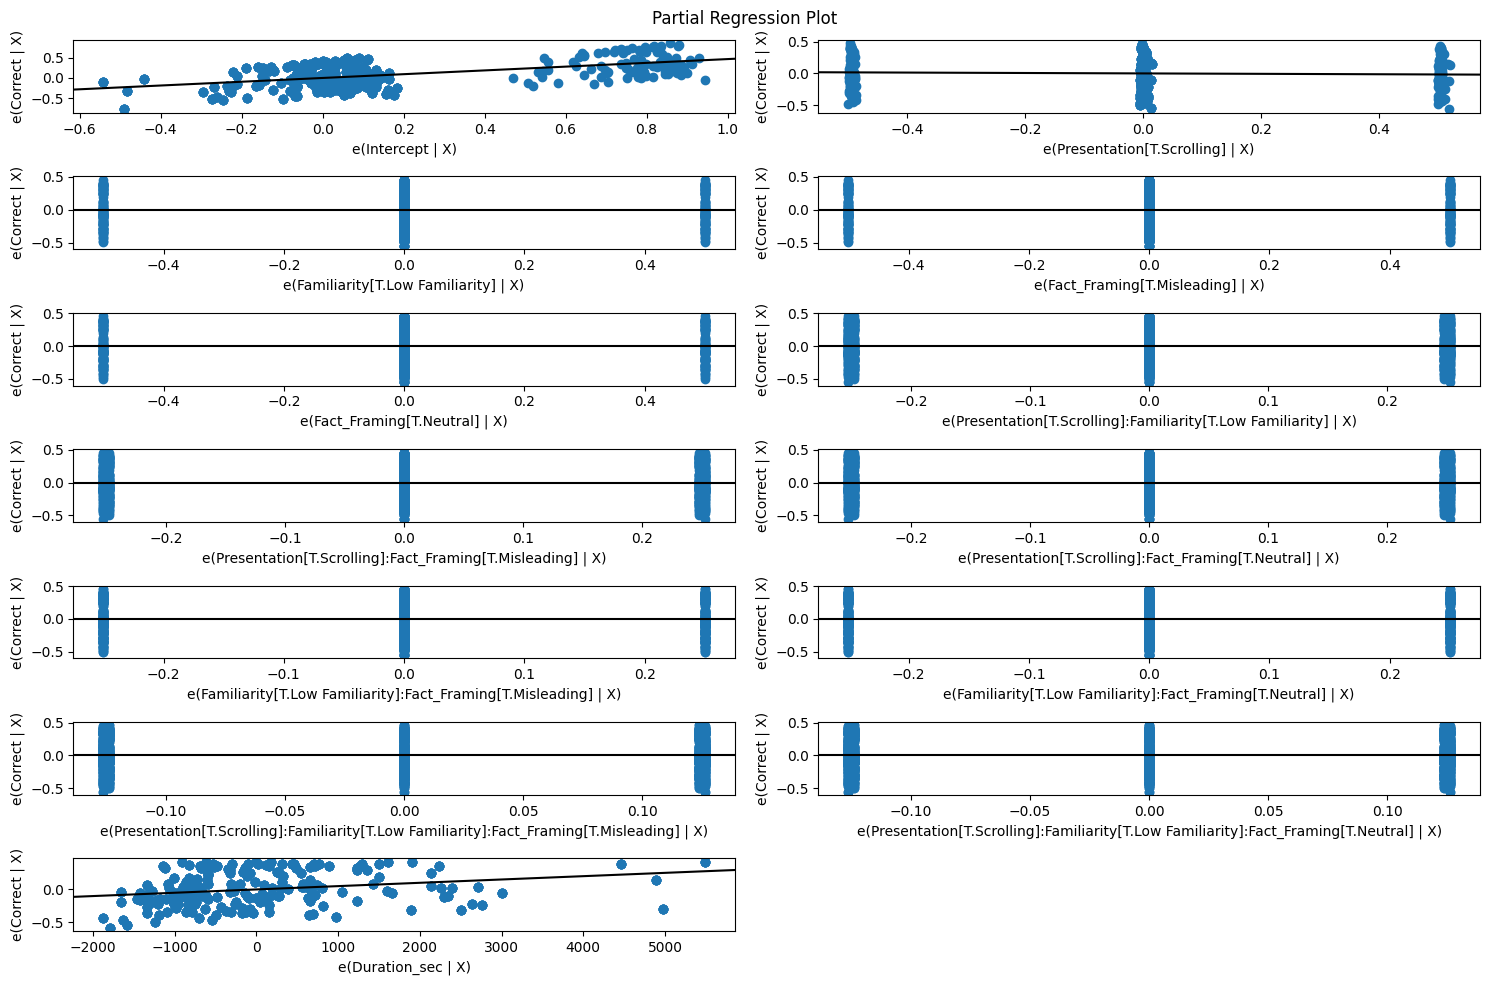

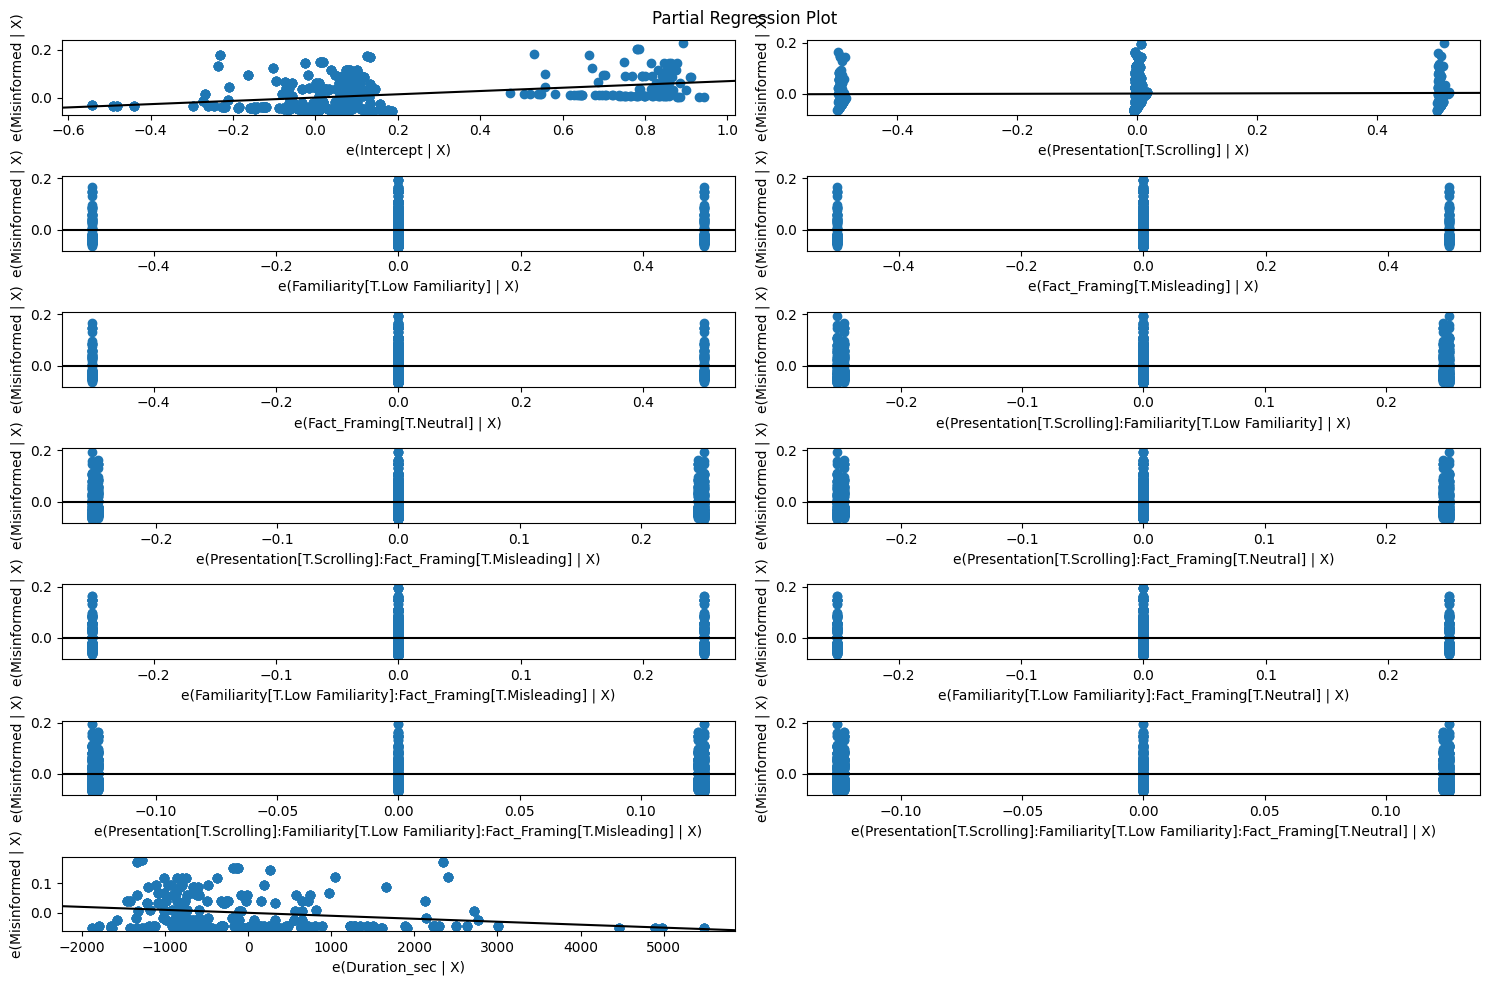

Breusch-Pagan test p-value for Correct model: 0.08827586652018901
Breusch-Pagan test p-value for Misinformed model: 0.9682627357659667


In [47]:
# Plot diagnostics for the ANCOVA model for correct responses
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_correct_ancova, fig=fig)
plt.show()

# Plot diagnostics for the ANCOVA model for misinformed responses
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_misinformed_ancova, fig=fig)
plt.show()

# Check for homoscedasticity using Breusch-Pagan test
_, pval_correct, __, f_pval_correct = sm.stats.diagnostic.het_breuschpagan(model_correct_ancova.resid, model_correct_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Correct model: {pval_correct}")

_, pval_misinformed, __, f_pval_misinformed = sm.stats.diagnostic.het_breuschpagan(model_misinformed_ancova.resid, model_misinformed_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Misinformed model: {pval_misinformed}")

## Raw Count Analyses

In [48]:
# Mixed-Effect Logistic Regression for Correct Responses (Raw Counts)
model_correct_raw = smf.mixedlm("Correct_Binary ~ Presentation * Familiarity * Fact_Framing + Duration_sec",
                                long_df,
                                groups=long_df["ID"],
                                re_formula="~1")
result_correct_raw = model_correct_raw.fit()
print("Mixed Effects Results for Correct Responses (Raw Counts):")
print(result_correct_raw.summary())

# Mixed-Effect Logistic Regression for Misinformed Responses (Raw Counts)
model_misinformed_raw = smf.mixedlm("Misinformed_Binary ~ Presentation * Familiarity * Fact_Framing + Duration_sec",
                                    long_df,
                                    groups=long_df["ID"],
                                    re_formula="~1")
result_misinformed_raw = model_misinformed_raw.fit()
print("Mixed Effects Results for Misinformed Responses (Raw Counts):")
print(result_misinformed_raw.summary())


Mixed Effects Results for Correct Responses (Raw Counts):
                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       Correct_Binary
No. Observations:                        7200                          Method:                                   REML          
No. Groups:                              200                           Scale:                                    0.1618        
Min. group size:                         36                            Log-Likelihood:                           -3957.3205    
Max. group size:                         36                            Converged:                                Yes           
Mean group size:                         36.0                                                                                  
-------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [50]:
# ANCOVA for Correct Responses (Raw Counts)
model_formula_correct_raw = 'Correct ~ Presentation * Familiarity * Fact_Framing + Duration_sec'
model_correct_raw_ancova = ols(model_formula_correct_raw, data=long_df).fit()
ancova_correct_raw = sm.stats.anova_lm(model_correct_raw_ancova, typ=2)
print("ANCOVA Results for Correct Raw Count:")
print(ancova_correct_raw)
print(model_correct_raw_ancova.summary())

# Post Hoc for Correct Responses (Raw Counts)
mc_correct_raw = mc.MultiComparison(long_df['Correct_Binary'], long_df['Presentation'].astype(str) + ':' + long_df['Familiarity'].astype(str) + ':' + long_df['Fact_Framing'].astype(str))
posthoc_correct_raw_results = mc_correct_raw.tukeyhsd()
print("Post-hoc results for Correct Raw Counts:")
print(posthoc_correct_raw_results)

# ANCOVA for Misinformed Responses (Raw Counts)
model_formula_misinformed_raw = 'Misinformed ~ Presentation * Familiarity * Fact_Framing + Duration_sec'
model_misinformed_raw_ancova = ols(model_formula_misinformed_raw, data=long_df).fit()
ancova_misinformed_raw = sm.stats.anova_lm(model_misinformed_raw_ancova, typ=2)
print("ANCOVA Results for Misinformed Raw Count:")
print(ancova_misinformed_raw)
print(model_misinformed_raw_ancova.summary())

# Post Hoc for Misinformed Responses (Raw Counts)
mc_misinformed_raw = mc.MultiComparison(long_df['Misinformed_Binary'], long_df['Presentation'].astype(str) + ':' + long_df['Familiarity'].astype(str) + ':' + long_df['Fact_Framing'].astype(str))
posthoc_misinformed_raw_results = mc_misinformed_raw.tukeyhsd()
print("Post-hoc results for Misinformed Raw Counts:")
print(posthoc_misinformed_raw_results)


ANCOVA Results for Correct Raw Count:
                                             sum_sq      df             F  \
Presentation                           1.957418e+00     1.0  3.295947e+01   
Familiarity                            4.052233e-28     1.0  6.823248e-27   
Fact_Framing                           3.687063e-29     2.0  3.104182e-28   
Presentation:Familiarity               1.778381e-10     1.0  2.994480e-09   
Presentation:Fact_Framing              5.773865e-06     2.0  4.861087e-05   
Familiarity:Fact_Framing               6.213751e-02     2.0  5.231432e-01   
Presentation:Familiarity:Fact_Framing  3.672359e-02     2.0  3.091803e-01   
Duration_sec                           2.846371e+01     1.0  4.792788e+02   
Residual                               4.268261e+02  7187.0           NaN   

                                              PR(>F)  
Presentation                            9.793395e-09  
Familiarity                             1.000000e+00  
Fact_Framing              

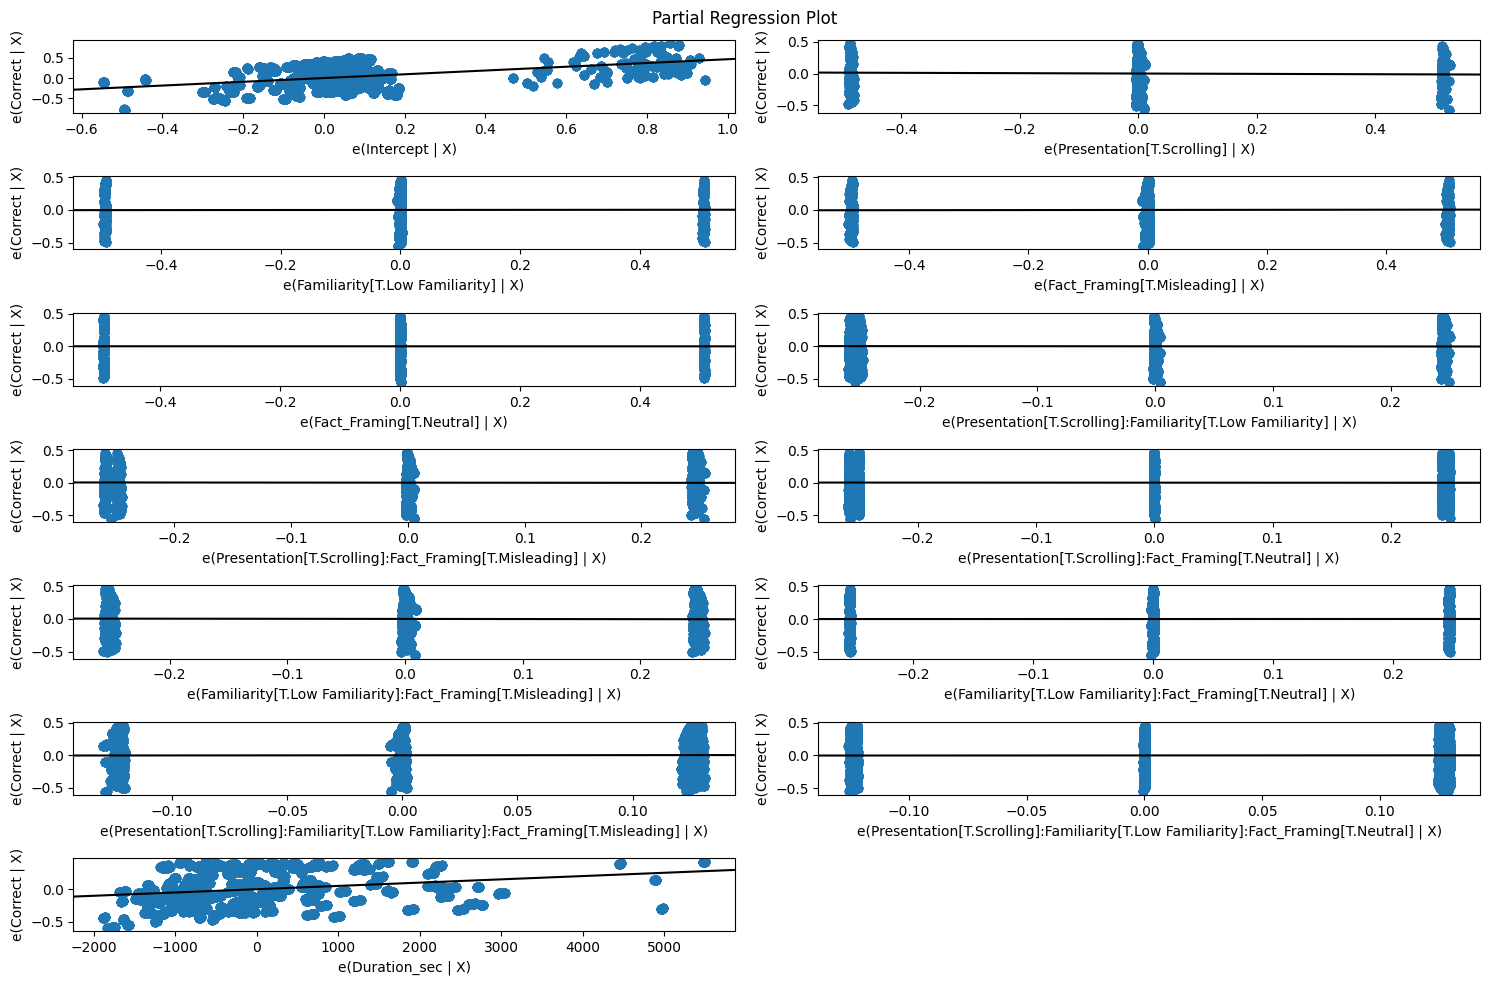

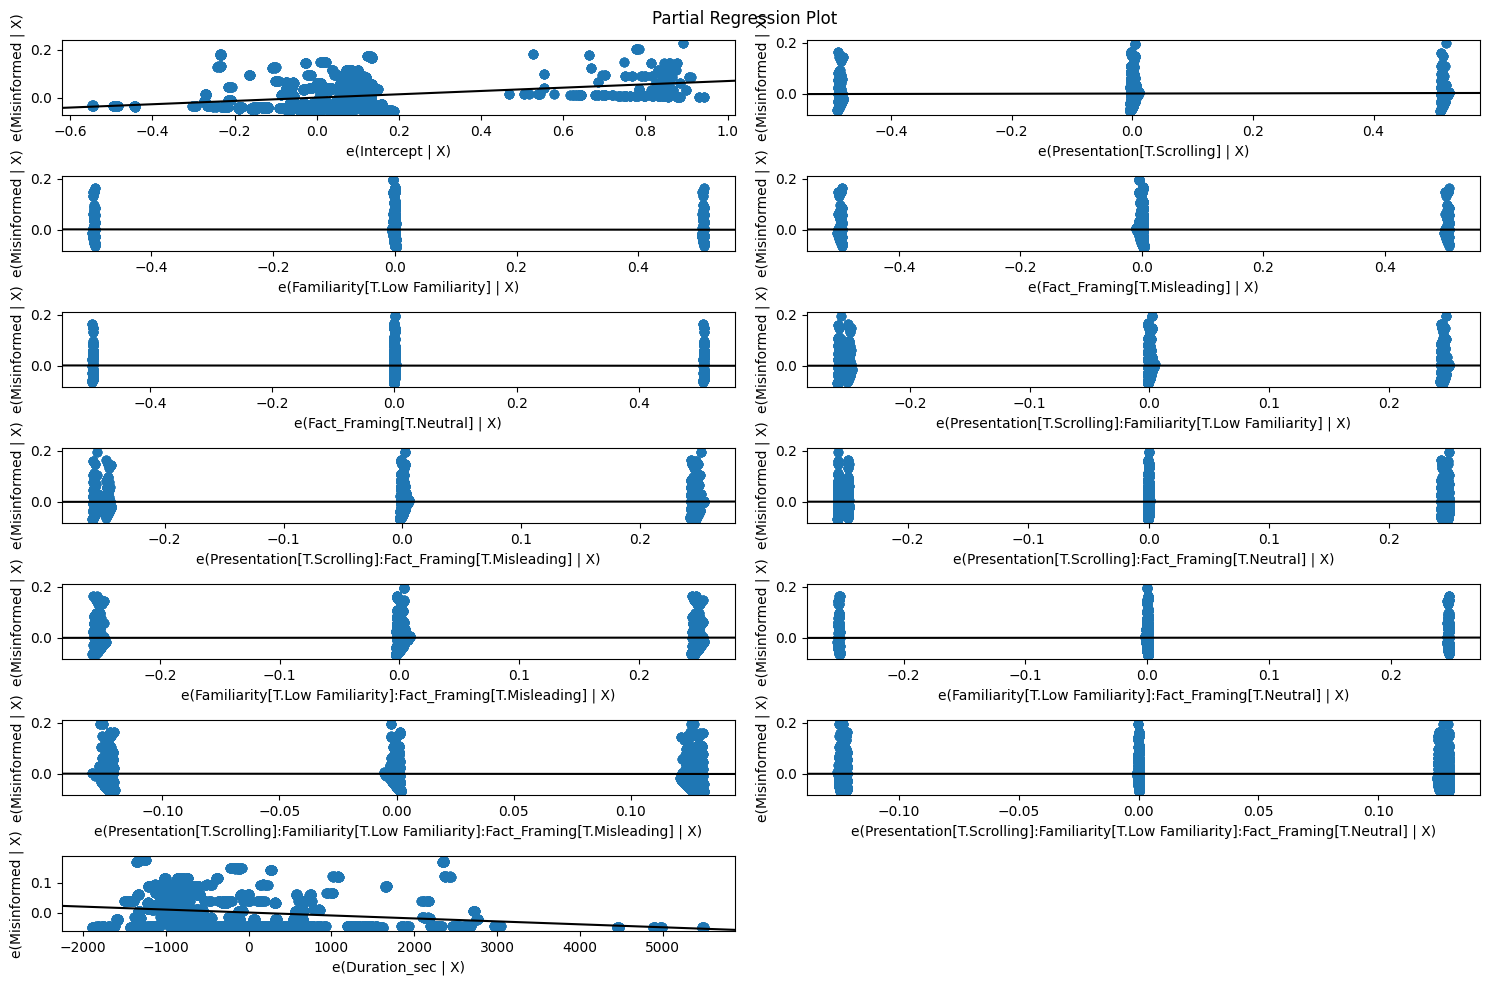

Breusch-Pagan test p-value for Correct model (Raw Counts): 7.704664514087061e-20
Breusch-Pagan test p-value for Misinformed model (Raw Counts): 0.0020166219655324245


In [51]:
# Plot diagnostics for the ANCOVA model for correct responses (Raw Counts)
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_correct_raw_ancova, fig=fig)
plt.show()

# Plot diagnostics for the ANCOVA model for misinformed responses (Raw Counts)
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_misinformed_raw_ancova, fig=fig)
plt.show()

# Check for homoscedasticity using Breusch-Pagan test (Raw Counts)
_, pval_correct_raw, __, f_pval_correct_raw = sm.stats.diagnostic.het_breuschpagan(model_correct_raw_ancova.resid, model_correct_raw_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Correct model (Raw Counts): {pval_correct_raw}")

_, pval_misinformed_raw, __, f_pval_misinformed_raw = sm.stats.diagnostic.het_breuschpagan(model_misinformed_raw_ancova.resid, model_misinformed_raw_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Misinformed model (Raw Counts): {pval_misinformed_raw}")


## Effect Sizes

In [52]:
# Define a function to calculate Hedge's g
def hedges_g(mean1, mean2, sd1, sd2, n1, n2):
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    g = (mean1 - mean2) / pooled_sd
    correction_factor = 1 - (3 / (4 * (n1 + n2) - 9))
    hedges_g_value = g * correction_factor
    return hedges_g_value

# Group by Presentation, Familiarity, and Fact Framing
grouped_lme = long_df.groupby(['Presentation', 'Familiarity', 'Fact_Framing'])

# Calculate means, standard deviations, and sample sizes
means_lme = grouped_lme['Correct_Binary'].mean()
sds_lme = grouped_lme['Correct_Binary'].std()
ns_lme = grouped_lme['Correct_Binary'].count()

# Define pairs for Hedge's g calculation based on significant results
significant_pairs_lme = [
    ('Scrolling', 'High Familiarity', 'Accurate', 'Page-based', 'High Familiarity', 'Accurate'),
    ('Scrolling', 'High Familiarity', 'Misleading', 'Page-based', 'High Familiarity', 'Misleading'),
    ('Scrolling', 'High Familiarity', 'Accurate', 'Scrolling', 'Low Familiarity', 'Accurate'),
    ('Page-based', 'High Familiarity', 'Accurate', 'Page-based', 'Low Familiarity', 'Accurate'),
    ('Scrolling', 'High Familiarity', 'Misleading', 'Scrolling', 'Low Familiarity', 'Misleading'),
    ('Page-based', 'High Familiarity', 'Misleading', 'Page-based', 'Low Familiarity', 'Misleading'),
    ('Scrolling', 'High Familiarity', 'Accurate', 'Scrolling', 'High Familiarity', 'Misleading'),
    ('Page-based', 'High Familiarity', 'Accurate', 'Page-based', 'High Familiarity', 'Misleading'),
    ('Scrolling', 'Low Familiarity', 'Accurate', 'Scrolling', 'Low Familiarity', 'Misleading'),
    ('Page-based', 'Low Familiarity', 'Accurate', 'Page-based', 'Low Familiarity', 'Misleading')
]

# Calculate Hedge's g for each pair
hedges_g_values_lme = {}
for (p1, d1, f1, p2, d2, f2) in significant_pairs_lme:
    mean1, mean2 = means_lme.loc[(p1, d1, f1)], means_lme.loc[(p2, d2, f2)]
    sd1, sd2 = sds_lme.loc[(p1, d1, f1)], sds_lme.loc[(p2, d2, f2)]
    n1, n2 = ns_lme.loc[(p1, d1, f1)], ns_lme.loc[(p2, d2, f2)]
    g = hedges_g(mean1, mean2, sd1, sd2, n1, n2)
    hedges_g_values_lme[((p1, d1, f1), (p2, d2, f2))] = g

# Print Hedge's g values
print("Hedge's g for Mixed Effects Model:")
for groups, g_value in hedges_g_values_lme.items():
    print(f"Hedge's g for {groups}: {g_value}")


Hedge's g for Mixed Effects Model:
Hedge's g for (('Scrolling', 'High Familiarity', 'Accurate'), ('Page-based', 'High Familiarity', 'Accurate')): -0.03293305001703053
Hedge's g for (('Scrolling', 'High Familiarity', 'Misleading'), ('Page-based', 'High Familiarity', 'Misleading')): -0.19917872486892887
Hedge's g for (('Scrolling', 'High Familiarity', 'Accurate'), ('Scrolling', 'Low Familiarity', 'Accurate')): 0.6930668208222985
Hedge's g for (('Page-based', 'High Familiarity', 'Accurate'), ('Page-based', 'Low Familiarity', 'Accurate')): 0.5551461678307106
Hedge's g for (('Scrolling', 'High Familiarity', 'Misleading'), ('Scrolling', 'Low Familiarity', 'Misleading')): 0.5506614592978588
Hedge's g for (('Page-based', 'High Familiarity', 'Misleading'), ('Page-based', 'Low Familiarity', 'Misleading')): 0.7020947631629721
Hedge's g for (('Scrolling', 'High Familiarity', 'Accurate'), ('Scrolling', 'High Familiarity', 'Misleading')): 0.24679186964934408
Hedge's g for (('Page-based', 'High Famil

<ipython-input-52-6d00f7caa443>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_lme = long_df.groupby(['Presentation', 'Familiarity', 'Fact_Framing'])


In [53]:
# Group by Presentation, Familiarity, and Fact Framing
grouped_proportions = proportions_df.groupby(['Presentation', 'Familiarity', 'Fact_Framing'])
grouped_raw = long_df.groupby(['Presentation', 'Familiarity', 'Fact_Framing'])

# Calculate means, standard deviations, and sample sizes
means_proportions = grouped_proportions['Correct'].mean()
sds_proportions = grouped_proportions['Correct'].std()
ns_proportions = grouped_proportions['Correct'].count()

means_raw = grouped_raw['Correct_Binary'].mean()
sds_raw = grouped_raw['Correct_Binary'].std()
ns_raw = grouped_raw['Correct_Binary'].count()

# Calculate Hedge's g for Proportions
hedges_g_values_proportions = {}
for (p1, d1, f1, p2, d2, f2) in significant_pairs_lme:
    mean1, mean2 = means_proportions.loc[(p1, d1, f1)], means_proportions.loc[(p2, d2, f2)]
    sd1, sd2 = sds_proportions.loc[(p1, d1, f1)], sds_proportions.loc[(p2, d2, f2)]
    n1, n2 = ns_proportions.loc[(p1, d1, f1)], ns_proportions.loc[(p2, d2, f2)]
    g = hedges_g(mean1, mean2, sd1, sd2, n1, n2)
    hedges_g_values_proportions[((p1, d1, f1), (p2, d2, f2))] = g

print("Hedge's g for Proportions:")
for groups, g_value in hedges_g_values_proportions.items():
    print(f"Hedge's g for {groups}: {g_value}")

# Calculate Hedge's g for Raw Counts
hedges_g_values_raw = {}
for (p1, d1, f1, p2, d2, f2) in significant_pairs_lme:
    mean1, mean2 = means_raw.loc[(p1, d1, f1)], means_raw.loc[(p2, d2, f2)]
    sd1, sd2 = sds_raw.loc[(p1, d1, f1)], sds_raw.loc[(p2, d2, f2)]
    n1, n2 = ns_raw.loc[(p1, d1, f1)], ns_raw.loc[(p2, d2, f2)]
    g = hedges_g(mean1, mean2, sd1, sd2, n1, n2)
    hedges_g_values_raw[((p1, d1, f1), (p2, d2, f2))] = g

print("Hedge's g for Raw Counts:")
for groups, g_value in hedges_g_values_raw.items():
    print(f"Hedge's g for {groups}: {g_value}")


Hedge's g for Proportions:
Hedge's g for (('Scrolling', 'High Familiarity', 'Accurate'), ('Page-based', 'High Familiarity', 'Accurate')): -0.1511421453714321
Hedge's g for (('Scrolling', 'High Familiarity', 'Misleading'), ('Page-based', 'High Familiarity', 'Misleading')): -0.1511421453714321
Hedge's g for (('Scrolling', 'High Familiarity', 'Accurate'), ('Scrolling', 'Low Familiarity', 'Accurate')): 0.0
Hedge's g for (('Page-based', 'High Familiarity', 'Accurate'), ('Page-based', 'Low Familiarity', 'Accurate')): 0.0
Hedge's g for (('Scrolling', 'High Familiarity', 'Misleading'), ('Scrolling', 'Low Familiarity', 'Misleading')): 0.0
Hedge's g for (('Page-based', 'High Familiarity', 'Misleading'), ('Page-based', 'Low Familiarity', 'Misleading')): 0.0
Hedge's g for (('Scrolling', 'High Familiarity', 'Accurate'), ('Scrolling', 'High Familiarity', 'Misleading')): 0.0
Hedge's g for (('Page-based', 'High Familiarity', 'Accurate'), ('Page-based', 'High Familiarity', 'Misleading')): 0.0
Hedge's g

<ipython-input-53-526c38a50fff>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_proportions = proportions_df.groupby(['Presentation', 'Familiarity', 'Fact_Framing'])
<ipython-input-53-526c38a50fff>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_raw = long_df.groupby(['Presentation', 'Familiarity', 'Fact_Framing'])


## All the Plots

In [54]:
# Define a function to save the plots
def save_plot(fig, filename):
    fig.savefig(filename, bbox_inches='tight')

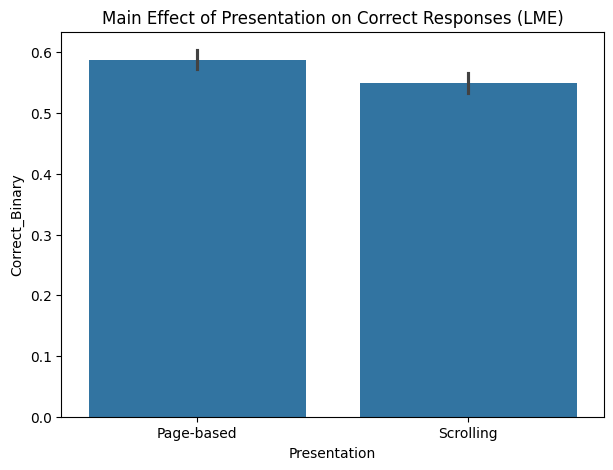

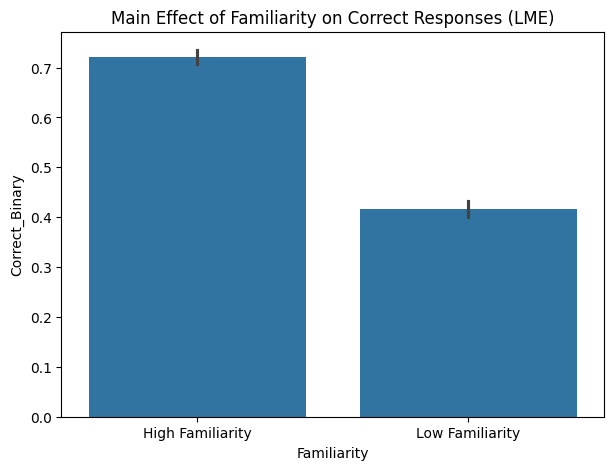

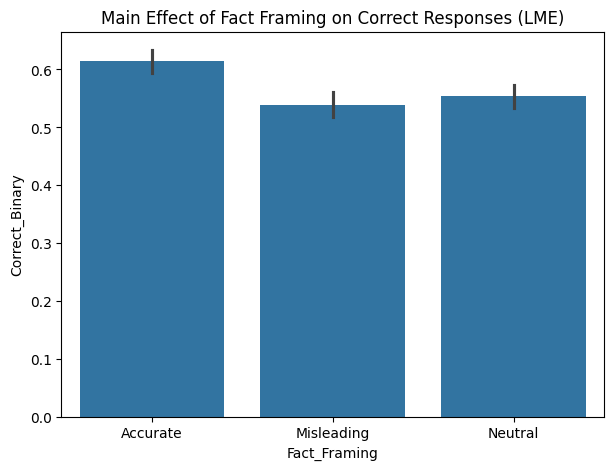

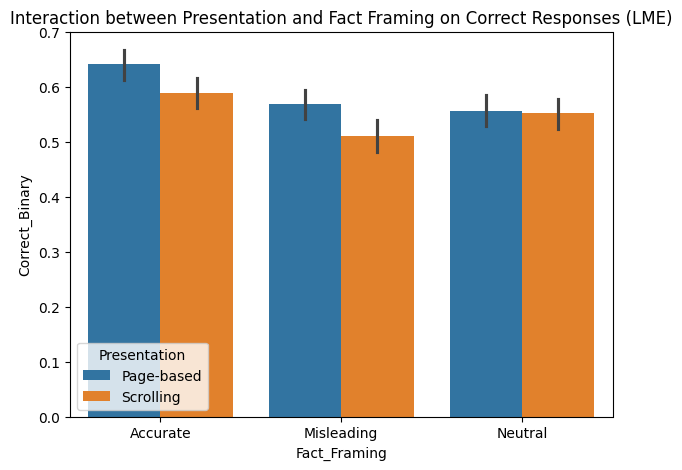

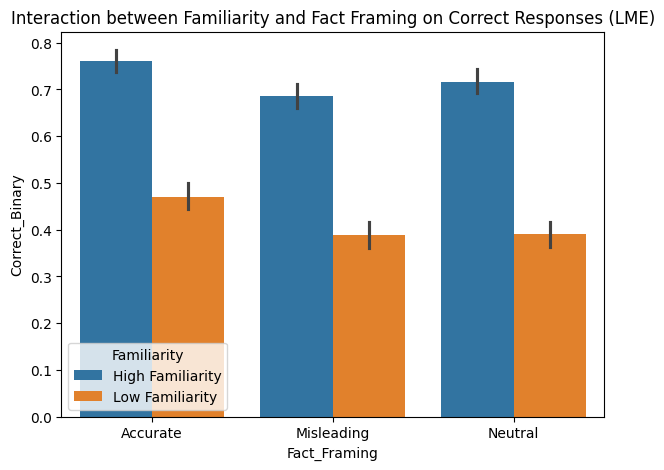

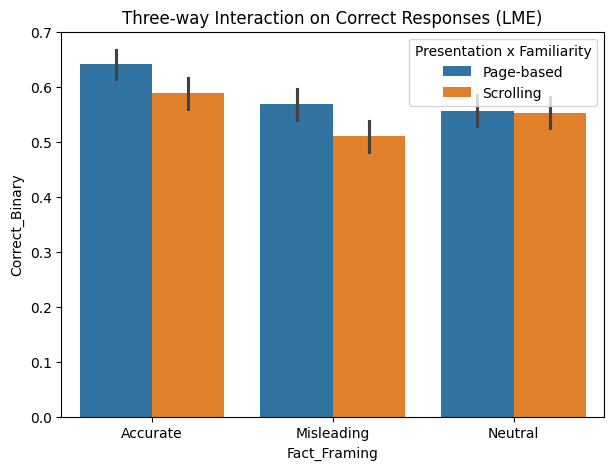

In [55]:
# Plots for Mixed Effects Model (Correct)
# Main effect of Presentation on Correct Responses
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Correct_Binary')
plt.title('Main Effect of Presentation on Correct Responses (LME)')
save_plot(fig1, 'main_effect_presentation_correct_lme.png')
plt.show()

# Main effect of Familiarityon Correct Responses
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Familiarity', y='Correct_Binary')
plt.title('Main Effect of Familiarity on Correct Responses (LME)')
save_plot(fig2, 'main_effect_familiarity_correct_lme.png')
plt.show()

# Main effect of Fact Framing on Correct Responses
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary')
plt.title('Main Effect of Fact Framing on Correct Responses (LME)')
save_plot(fig3, 'main_effect_fact_framing_correct_lme.png')
plt.show()

# Interaction between Presentation and Fact Framing on Correct Responses
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Correct Responses (LME)')
save_plot(fig4, 'interaction_presentation_fact_framing_correct_lme.png')
plt.show()

# Interaction between Familiarity and Fact Framing on Correct Responses
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Familiarity')
plt.title('Interaction between Familiarity and Fact Framing on Correct Responses (LME)')
save_plot(fig5, 'interaction_familiarity_fact_framing_correct_lme.png')
plt.show()

# Three-way interaction on Correct Responses
fig6 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Three-way Interaction on Correct Responses (LME)')
plt.legend(title='Presentation x Familiarity', loc='upper right')
save_plot(fig6, 'three_way_interaction_correct_lme.png')
plt.show()


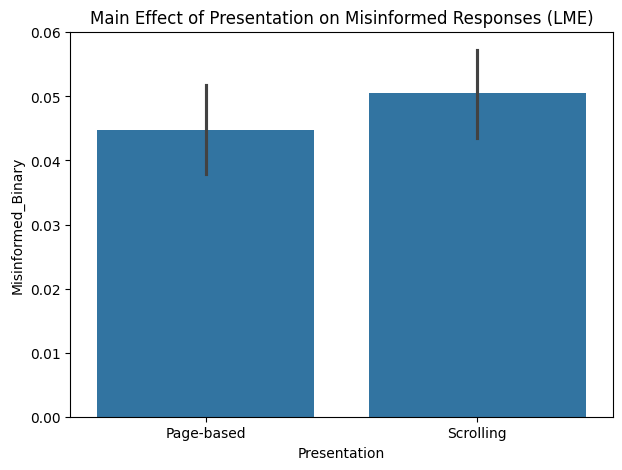

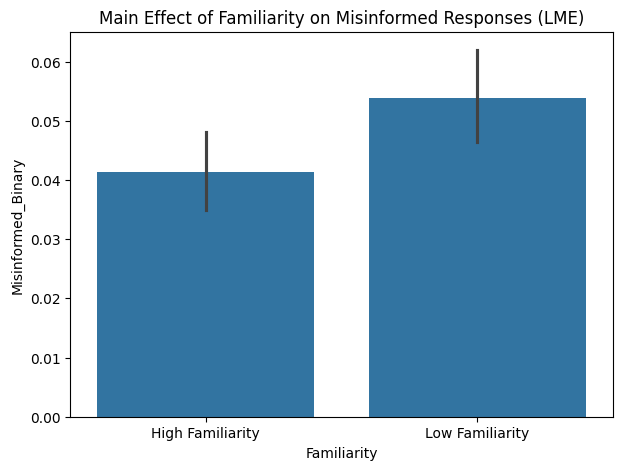

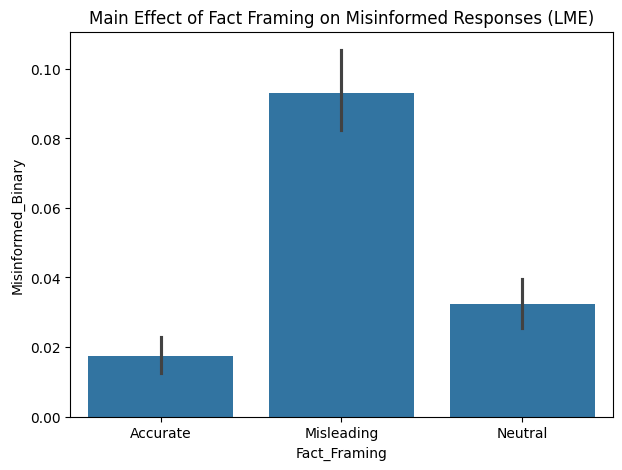

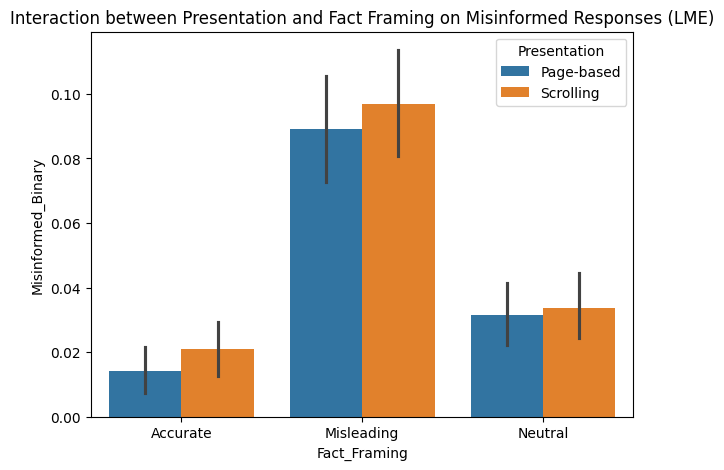

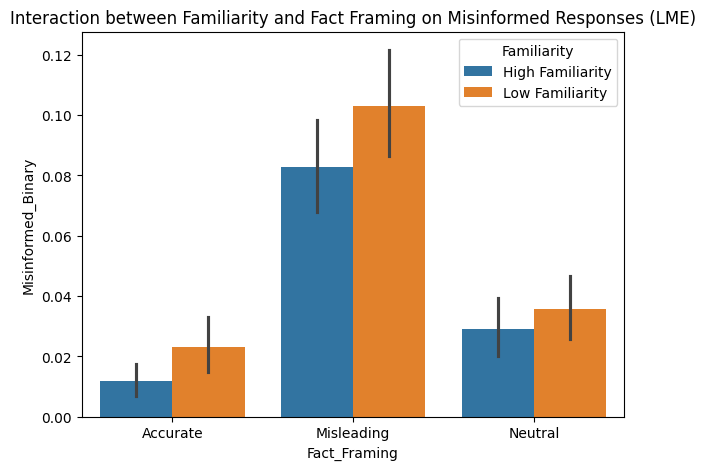

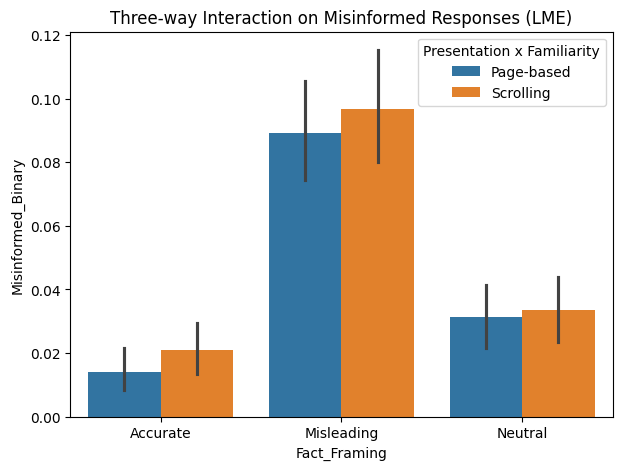

In [57]:
# Plots for Mixed Effects Model (Misinformed)
# Main effect of Presentation on Misinformed Responses
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Misinformed_Binary')
plt.title('Main Effect of Presentation on Misinformed Responses (LME)')
save_plot(fig1, 'main_effect_presentation_misinformed_lme.png')
plt.show()

# Main effect of Familiarity on Misinformed Responses
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Familiarity', y='Misinformed_Binary')
plt.title('Main Effect of Familiarity on Misinformed Responses (LME)')
save_plot(fig2, 'main_effect_familiarity_misinformed_lme.png')
plt.show()

# Main effect of Fact Framing on Misinformed Responses
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Misinformed_Binary')
plt.title('Main Effect of Fact Framing on Misinformed Responses (LME)')
save_plot(fig3, 'main_effect_fact_framing_misinformed_lme.png')
plt.show()

# Interaction between Presentation and Fact Framing on Misinformed Responses
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Misinformed_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Misinformed Responses (LME)')
save_plot(fig4, 'interaction_presentation_fact_framing_misinformed_lme.png')
plt.show()

# Interaction between Familiarity and Fact Framing on Misinformed Responses
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Misinformed_Binary', hue='Familiarity')
plt.title('Interaction between Familiarity and Fact Framing on Misinformed Responses (LME)')
save_plot(fig5, 'interaction_familiarity_fact_framing_misinformed_lme.png')
plt.show()

# Three-way interaction on Misinformed Responses
fig6 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Misinformed_Binary', hue='Presentation')
plt.title('Three-way Interaction on Misinformed Responses (LME)')
plt.legend(title='Presentation x Familiarity', loc='upper right')
save_plot(fig6, 'three_way_interaction_misinformed_lme.png')
plt.show()

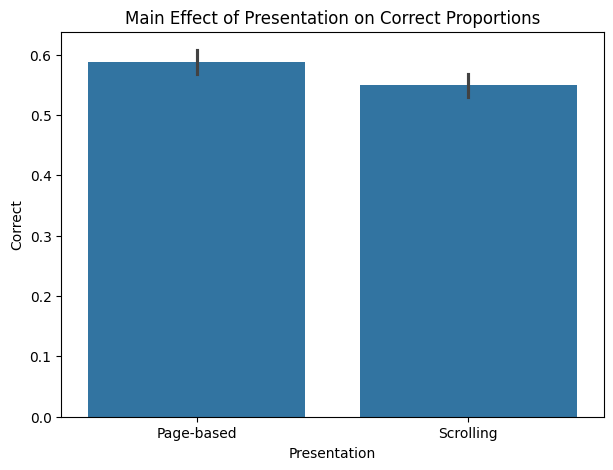

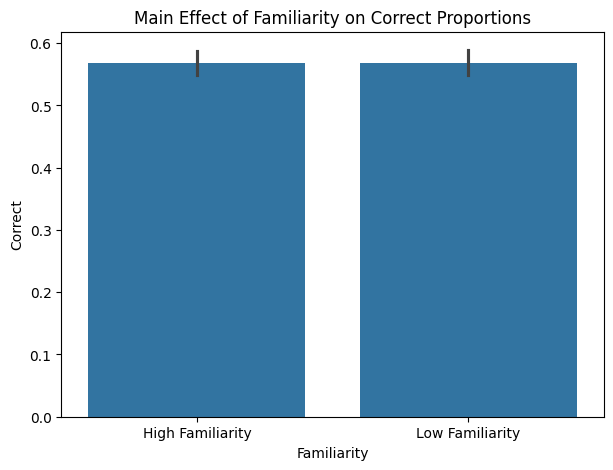

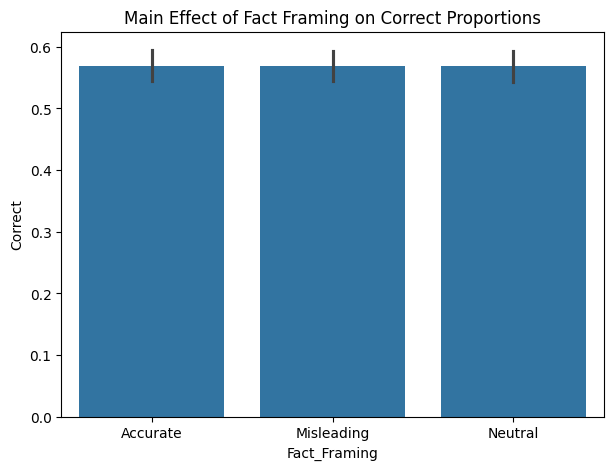

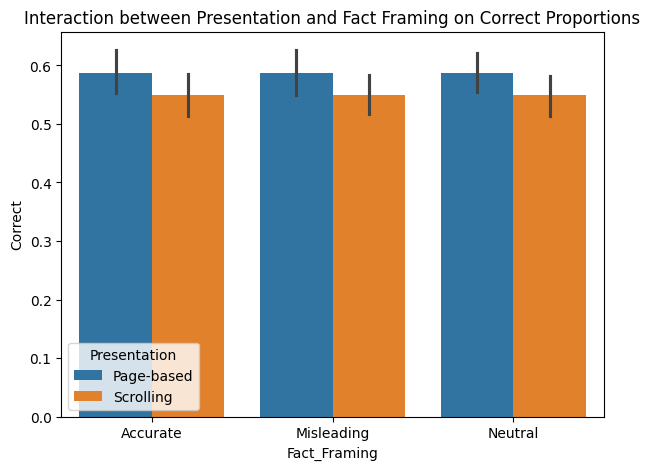

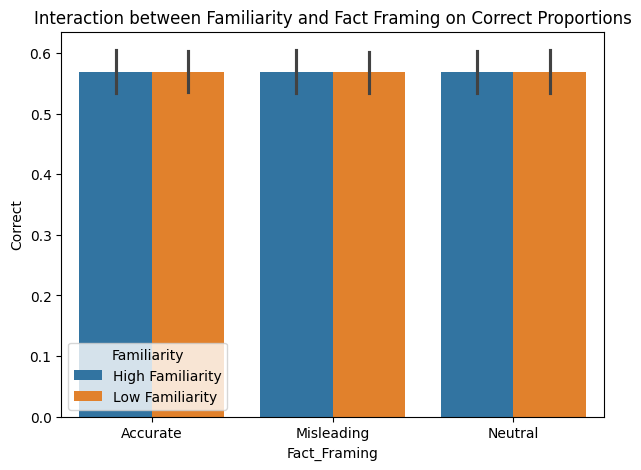

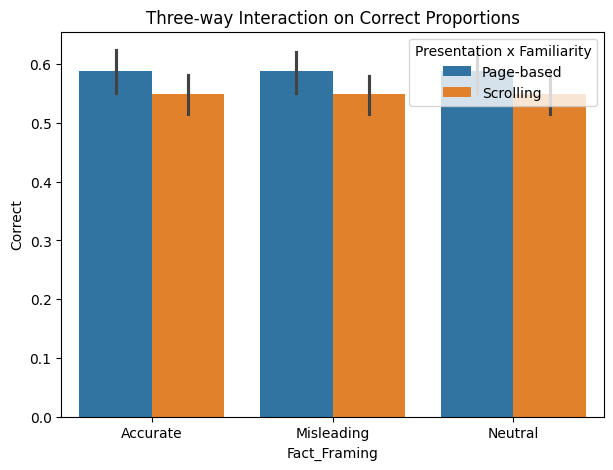

In [58]:
# Plots for Proportions
# Main effect of Presentation on Correct Proportions
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Presentation', y='Correct')
plt.title('Main Effect of Presentation on Correct Proportions')
save_plot(fig1, 'main_effect_presentation_correct_proportions.png')
plt.show()

# Main effect of Familiarity on Correct Proportions
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Familiarity', y='Correct')
plt.title('Main Effect of Familiarity on Correct Proportions')
save_plot(fig2, 'main_effect_familiarity_correct_proportions.png')
plt.show()

# Main effect of Fact Framing on Correct Proportions
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct')
plt.title('Main Effect of Fact Framing on Correct Proportions')
save_plot(fig3, 'main_effect_fact_framing_correct_proportions.png')
plt.show()

# Interaction between Presentation and Fact Framing on Correct Proportions
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Correct Proportions')
save_plot(fig4, 'interaction_presentation_fact_framing_correct_proportions.png')
plt.show()

# Interaction between Familiarity and Fact Framing on Correct Proportions
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct', hue='Familiarity')
plt.title('Interaction between Familiarity and Fact Framing on Correct Proportions')
save_plot(fig5, 'interaction_familiarity_fact_framing_correct_proportions.png')
plt.show()

# Three-way interaction on Correct Proportions
fig6 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct', hue='Presentation')
plt.title('Three-way Interaction on Correct Proportions')
plt.legend(title='Presentation x Familiarity', loc='upper right')
save_plot(fig6, 'three_way_interaction_correct_proportions.png')
plt.show()


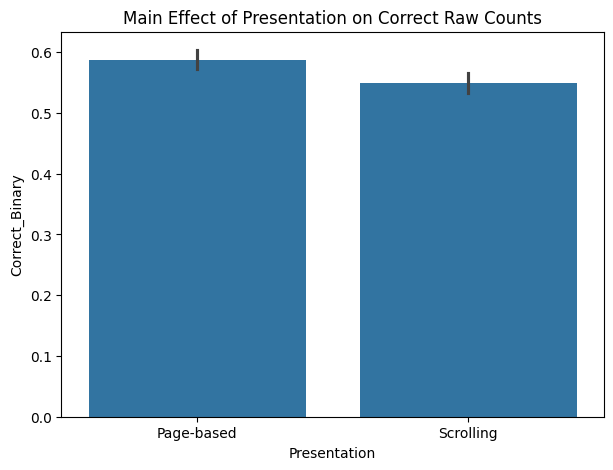

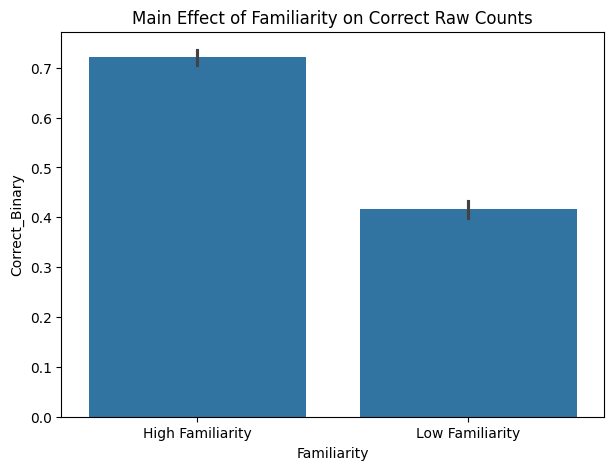

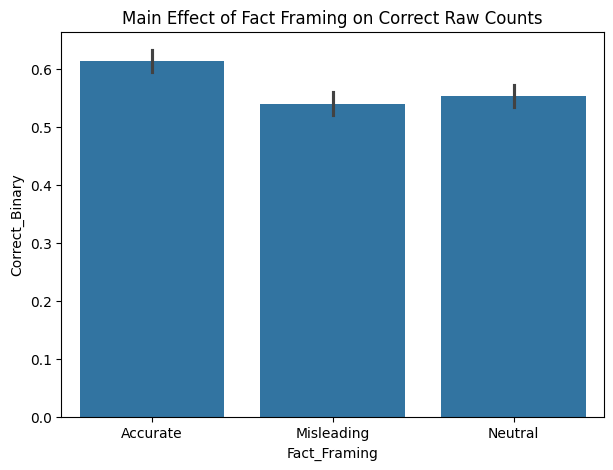

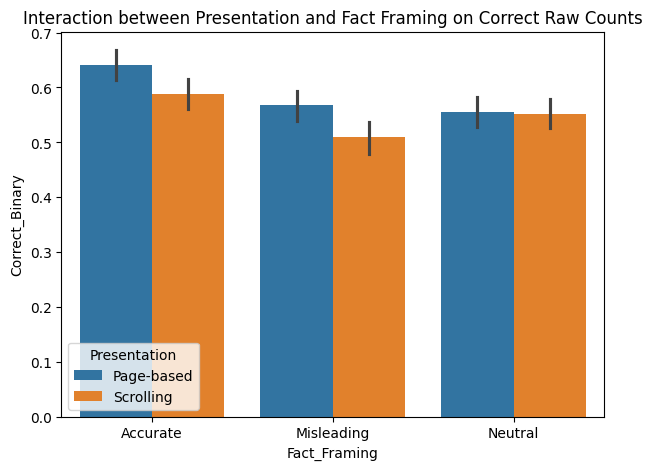

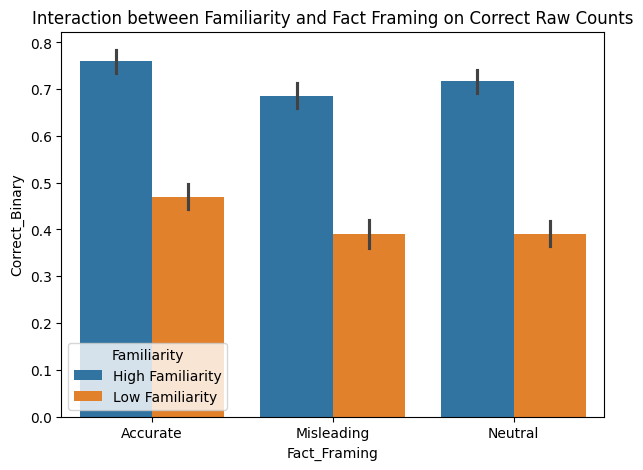

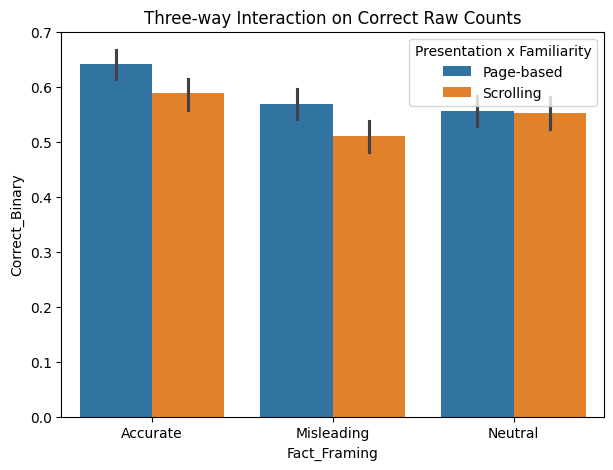

In [60]:
# Plots for Raw Counts
# Main effect of Presentation on Correct Raw Counts
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Correct_Binary')
plt.title('Main Effect of Presentation on Correct Raw Counts')
save_plot(fig1, 'main_effect_presentation_correct_raw.png')
plt.show()

# Main effect of Familiarity on Correct Raw Counts
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Familiarity', y='Correct_Binary')
plt.title('Main Effect of Familiarity on Correct Raw Counts')
save_plot(fig2, 'main_effect_familiarity_correct_raw.png')
plt.show()

# Main effect of Fact Framing on Correct Raw Counts
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary')
plt.title('Main Effect of Fact Framing on Correct Raw Counts')
save_plot(fig3, 'main_effect_fact_framing_correct_raw.png')
plt.show()

# Interaction between Presentation and Fact Framing on Correct Raw Counts
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Correct Raw Counts')
save_plot(fig4, 'interaction_presentation_fact_framing_correct_raw.png')
plt.show()

# Interaction between Familiarity and Fact Framing on Correct Raw Counts
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Familiarity')
plt.title('Interaction between Familiarity and Fact Framing on Correct Raw Counts')
save_plot(fig5, 'interaction_familiarity_fact_framing_correct_raw.png')
plt.show()

# Three-way interaction on Correct Raw Counts
fig6 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Three-way Interaction on Correct Raw Counts')
plt.legend(title='Presentation x Familiarity', loc='upper right')
save_plot(fig6, 'three_way_interaction_correct_raw.png')
plt.show()


## Optional Follow Ups

### Bootstrapping

In [61]:
from sklearn.utils import resample

def bootstrap(data, n_iterations, sample_size, func):
    statistics = []
    for i in range(n_iterations):
        sample = resample(data, n_samples=sample_size)
        statistic = func(sample)
        statistics.append(statistic)
    return np.percentile(statistics, [2.5, 97.5])

# Bootstrap 95% CI for mean Correct proportion
bootstrap_correct = bootstrap(proportions_df['Correct'], 1000, len(proportions_df), np.mean)
print("Bootstrap 95% CI for Correct Proportion:", bootstrap_correct)

# Bootstrap 95% CI for mean Misinformed proportion
bootstrap_misinformed = bootstrap(proportions_df['Misinformed'], 1000, len(proportions_df), np.mean)
print("Bootstrap 95% CI for Misinformed Proportion:", bootstrap_misinformed)


Bootstrap 95% CI for Correct Proportion: [0.55458102 0.58317188]
Bootstrap 95% CI for Misinformed Proportion: [0.04423553 0.05106481]


Robust Regression (ANCOVA)

In [62]:
import statsmodels.formula.api as smf

# Huber regression for Correct Proportion
model_huber_correct = smf.rlm('Correct ~ Presentation * Familiarity * Fact_Framing + Duration_sec', data=proportions_df, M=sm.robust.norms.HuberT())
results_huber_correct = model_huber_correct.fit()
print("Huber Regression Results for Correct Proportion:")
print(results_huber_correct.summary())

# Huber regression for Misinformed Proportion
model_huber_misinformed = smf.rlm('Misinformed ~ Presentation * Familiarity * Fact_Framing + Duration_sec', data=proportions_df, M=sm.robust.norms.HuberT())
results_huber_misinformed = model_huber_misinformed.fit()
print("Huber Regression Results for Misinformed Proportion:")
print(results_huber_misinformed.summary())


Huber Regression Results for Correct Proportion:
                    Robust linear Model Regression Results                    
Dep. Variable:                Correct   No. Observations:                 1200
Model:                            RLM   Df Residuals:                     1187
Method:                          IRLS   Df Model:                           12
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 02 Feb 2025                                         
Time:                        17:36:31                                         
No. Iterations:                    16                                         
                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------

###  Mixed Effects Model with Robust Standard Errors

In [63]:
# Mixed Effects Model for Correct Responses
model_correct_robust = smf.mixedlm("Correct_Binary ~ Presentation * Familiarity * Fact_Framing + Duration_sec",
                                   long_df,
                                   groups=long_df["ID"],
                                   re_formula="~1")
result_correct_robust = model_correct_robust.fit(reml=True)
# Manually compute robust standard errors
robust_cov_correct = result_correct_robust.cov_params() * result_correct_robust.scale
robust_se_correct = np.sqrt(np.diag(robust_cov_correct))

print("Mixed Effects Model with Robust Standard Errors for Correct Responses:")
print(result_correct_robust.summary())
print("\nRobust Standard Errors:")
print(robust_se_correct)

# Mixed Effects Model for Misinformed Responses
model_misinformed_robust = smf.mixedlm("Misinformed_Binary ~ Presentation * Familiarity * Fact_Framing + Duration_sec",
                                       long_df,
                                       groups=long_df["ID"],
                                       re_formula="~1")
result_misinformed_robust = model_misinformed_robust.fit(reml=True)
# Manually compute robust standard errors
robust_cov_misinformed = result_misinformed_robust.cov_params() * result_misinformed_robust.scale
robust_se_misinformed = np.sqrt(np.diag(robust_cov_misinformed))

print("Mixed Effects Model with Robust Standard Errors for Misinformed Responses:")
print(result_misinformed_robust.summary())
print("\nRobust Standard Errors:")
print(robust_se_misinformed)


Mixed Effects Model with Robust Standard Errors for Correct Responses:
                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       Correct_Binary
No. Observations:                        7200                          Method:                                   REML          
No. Groups:                              200                           Scale:                                    0.1618        
Min. group size:                         36                            Log-Likelihood:                           -3957.3205    
Max. group size:                         36                            Converged:                                Yes           
Mean group size:                         36.0                                                                                  
------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Readme

# Experiment 1A General Knowledge Analysis

This repository contains the script and instructions to preprocess, analyze, and visualize data for Experiment 1A, which investigates the impact of presentation format, item familiarity, and fact framing on general knowledge recall. The analysis includes mixed effects models, ANCOVA, effect size calculations, and various plots to support the findings.

## Prerequisites

- Python 3.7 or higher
- Required Python libraries:
  - gspread
  - google-auth
  - google-auth-oauthlib
  - google-auth-httplib2
  - pandas
  - numpy
  - seaborn
  - matplotlib
  - statsmodels

## Setup

1. Clone the repository and navigate to the project directory.

2. Install the required Python libraries using pip:

    ```bash
    pip install gspread google-auth google-auth-oauthlib google-auth-httplib2 pandas numpy seaborn matplotlib statsmodels
    ```

3. Upload your `credentials.json` file to authenticate access to Google Sheets.

## Data Preprocessing

1. Load data from the specified Google Sheet.
2. Convert relevant columns to appropriate types and map categorical variables.
3. Convert data to long format and create binary response columns for `Correct_Binary` and `Misinformed_Binary`.

## Descriptive Statistics and Diagnostic Plots

1. Calculate and print descriptive statistics.
2. Generate diagnostic plots for assumption checks (normality, homoscedasticity, etc.).

## Mixed Effects Models

1. Fit mixed effects models for correct and misinformed responses.
2. Manually compute robust standard errors.

## ANCOVA Analyses

1. Perform ANCOVA on proportion data for correct and misinformed responses.
2. Conduct post-hoc analyses for significant results.

## Effect Size Calculations

1. Calculate Hedge's g for significant comparisons in both the mixed effects and ANCOVA results.
2. Calculate effect sizes for raw count data.

## Plotting Analysis Results

1. Generate and save plots for the main effects and interactions for both correct and misinformed responses (based on proportions and raw counts).

## Script Overview

The script is organized into the following sections:

1. **Setup and Data Loading:** Installs necessary libraries and loads data from Google Sheets.
2. **Data Preprocessing:** Converts data to long format and creates necessary columns.
3. **Descriptive Statistics:** Calculates and prints descriptive statistics, generates diagnostic plots.
4. **Mixed Effects Models with Robust Standard Errors:** Fits mixed effects models and computes robust standard errors.
5. **ANCOVA Analyses:** Performs ANCOVA on proportion data and conducts post-hoc analyses.
6. **Effect Size Calculations:** Calculates Hedge's g for significant comparisons.
7. **Plotting Analysis Results:** Generates and saves plots for main effects and interactions.

## Running the Script

1. Ensure you have the `credentials.json` file in your working dir
